# 0. IMPORTS

## 0.1 IMPORTS

In [1]:
import datetime
import math
import inflection
import warnings
import random

import pandas            as pd
import numpy             as np
import seaborn           as sns
import researchpy        as rp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xgboost           as xgb

from matplotlib.gridspec     import GridSpec
from IPython.display         import Image
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.metrics         import mean_absolute_error,  mean_absolute_percentage_error,  mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from boruta                  import BorutaPy

## 0.2 Helper Functions

In [2]:
def cramers_v(data, x, y):
    '''
    Function that calculates the correlation between 2 categorical features
    data: Dataset that contains the data
    x: Feature 1
    y: Feature 2
    Returns: Cramer's V coefficient
    '''
    
    return rp.crosstab(data[x], data[y], prop='col', test='chi-square')[1]['results'][2]


def ml_performance(model_name, y_test, y_hat):
    '''
    Function that returns the performance of a model, measure by MAE, MAPE, RSME and R2 score
    '''

    mae = mean_absolute_error(y_test, y_hat)
    mape = mean_absolute_percentage_error(y_test, y_hat)
    rmse = mean_squared_error(y_test, y_hat)
    r2score = r2_score(y_test, y_hat)

    return pd.DataFrame({
        'model_name': model_name,
        'MAE': round(mae, 2),
        'MAPE': round(mape, 4),
        'RMSE': round(np.sqrt(rmse), 2),
        'R2_SCORE': round(r2score, 4)}, index=[0])

def cross_validation_ts(X, y, model_name, model, n_splits=5):
    '''
    Function that performs time series cross validation for any given machine learning model. Date columns MUST be the last column in train dataset
    Inputs:
    X: Predictor features of training data
    y: Target feature of training data
    model_name: The name of the model (i.e. linear regression, lasso, random forest, etc)
    model: The basic machine learnig model
    n_splits(default=5): the number of splits in the data
    '''
    
    # create an instance of TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # create lists to store metrics
    mae_scores = []
    mape_scores = []
    rmse_scores = []
    r2_scores = []
    
    # make cross validation
    for train_index, val_index in tscv.split(X):
    
        # get train and validation datasets, excluding date column, that is not compatible
        X_train_cv, X_val_cv = X.iloc[train_index, :-1], X.iloc[val_index, :-1]
        y_train_cv, y_val_cv = y.loc[train_index], y.loc[val_index]
    
        # create model
        m = model
    
        # train model
        m.fit(X_train_cv, y_train_cv)
    
        # predict
        yhat = m.predict(X_val_cv)
    
        # calculate metrics
        mae_scores.append(mean_absolute_error(np.expm1(y_val_cv), np.expm1(yhat)))
        mape_scores.append(mean_absolute_percentage_error(np.expm1(y_val_cv), np.expm1(yhat)))
        rmse_scores.append(np.sqrt(mean_squared_error(np.expm1(y_val_cv), np.expm1(yhat))))
        r2_scores.append(r2_score(np.expm1(y_val_cv), np.expm1(yhat)))
    
    return pd.DataFrame({'MODEL': model_name,
                         'MAE_avg': f'{round(np.average(mae_scores), 2)} +/- {round(np.std(mae_scores), 2)}',
                         'MAPE_avg': f'{round(np.average(mape_scores), 2)} +/- {round(np.std(mape_scores), 2)}',
                         'RMSE_avg': f'{round(np.average(rmse_scores), 2)} +/- {round(np.std(rmse_scores), 2)}',
                         'R2_avg': f'{round(np.average(r2_scores), 2)} +/- {round(np.std(r2_scores), 2)}'}, index=[0])

## 0.3 Set Paramemters

In [3]:
# Set figure features
plt.rcParams['figure.figsize'] = (20, 8)

# Set seaborn parameters
sns.set_theme(context='notebook', palette='pastel')

# Ignore alers
warnings.filterwarnings('ignore')

# Set number format style
formatter = ticker.StrMethodFormatter("{x:,.0f}")

## 0.4 Loading Data

In [4]:
# Load sales dataframe
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)

# Load some store information
df_stores_raw = pd.read_csv('data/store.csv', low_memory=False)

# Merge dataframes to increase store information
df_raw = pd.merge(df_sales_raw, df_stores_raw, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1. DATA DESCRIPTION

In [5]:
# Make a dataframe copy
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
# Saving columns name to a new variable
cols_name = df1.columns.to_list()

# Create a lambda function to pass columns name to snake case
transform_snake_case = lambda x: inflection.underscore(x)

# Apply function and save new names on another variable
cols_name_new = list(map(transform_snake_case, cols_name))

# Renaming the columns
df1.columns = cols_name_new

## 1.2 Data Dimensions

In [7]:
print(f'The dataset have {df1.shape[0]} rows and {df1.shape[1]} columns')

The dataset have 1017209 rows and 18 columns


## 1.3 Data Types

In [8]:
# Change date format to datetime (it comes as string)
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA's

In [9]:
# Null data per column
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
# competition_distance (fill out with extreme values, assuming that null values does not have close competitor)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 150000.0 if math.isnan(x) else x)

# competition_open_since_month 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
                                                else (x['competition_open_since_month']), axis = 1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                                else (x['competition_open_since_year']), axis = 1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                                else (x['promo2_since_week']), axis = 1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                                else (x['promo2_since_year']), axis = 1)

# promo_interval
months = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(months)

df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 
                            else 1 if x['month_map'] in x['promo_interval'].split(',') 
                            else 0, axis=1)

## 1.6 Check Data Types

In [11]:
# Change data types from float to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics

In [13]:
# Central Tendency - mean, median
# Dispersion - std, min, max, range, skew, kurtosis

# Separating features into numerical and categorical

num_att = df1.select_dtypes(include=('int64', 'float64'))
cat_att = df1.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))

### 1.7.1 Numerical Attributes

In [14]:
# mean, median, std, min, quartiles, max
descriptive_num = num_att.describe().T

# range
descriptive_num['range'] = descriptive_num['max'] - descriptive_num['min']

# skew
skew = pd.DataFrame(num_att.apply(lambda x: x.skew()), columns=['skew'])

# kurtosis
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis()), columns=['kurtosis'])

# Drop columns
descriptive_num.drop(columns=['count'], inplace=True)

# Concat data
metrics = pd.concat([descriptive_num, skew, kurtosis], axis=1).reset_index()

# Rename columns
metrics.rename(columns={'50%': 'median', 'index': 'features'}, inplace=True)
    
# Reorder columns
metrics = metrics[['features', 'mean', 'median', 'min', 'max', 'range', '25%', '75%', 'std', 'skew', 'kurtosis']]
metrics

,features,mean,median,min,max,range,25%,75%,std,skew,kurtosis
0,store,558.429727,558.0,1.0,1115.0,1114.0,280.0,838.0,321.908651,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.0,7.0,6.0,2.0,6.0,1.997391,0.001593,-1.246873
2,sales,5773.818972,5744.0,0.0,41551.0,41551.0,3727.0,7856.0,3849.926175,0.641460,1.778375
3,customers,633.145946,609.0,0.0,7388.0,7388.0,405.0,837.0,464.411734,1.598650,7.091773
4,open,0.830107,1.0,0.0,1.0,1.0,1.0,1.0,0.375539,-1.758045,1.090723
5,promo,0.381515,0.0,0.0,1.0,1.0,0.0,1.0,0.485759,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.0,1.0,1.0,0.0,0.0,0.383056,1.677842,0.815154
7,competition_distance,5805.577526,2330.0,20.0,150000.0,149980.0,710.0,6910.0,10654.365263,7.492361,88.374150
8,promo2,0.500564,1.0,0.0,1.0,1.0,0.0,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.165966,0.0,0.0,1.0,1.0,0.0,0.0,0.372050,1.795644,1.224338


### 1.7.2 Categorical Attributes

In [15]:
# Drop month_map
cat_att.drop(columns=['month_map'], inplace=True)

# Show the number of categories
cat_att.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
dtype: int64

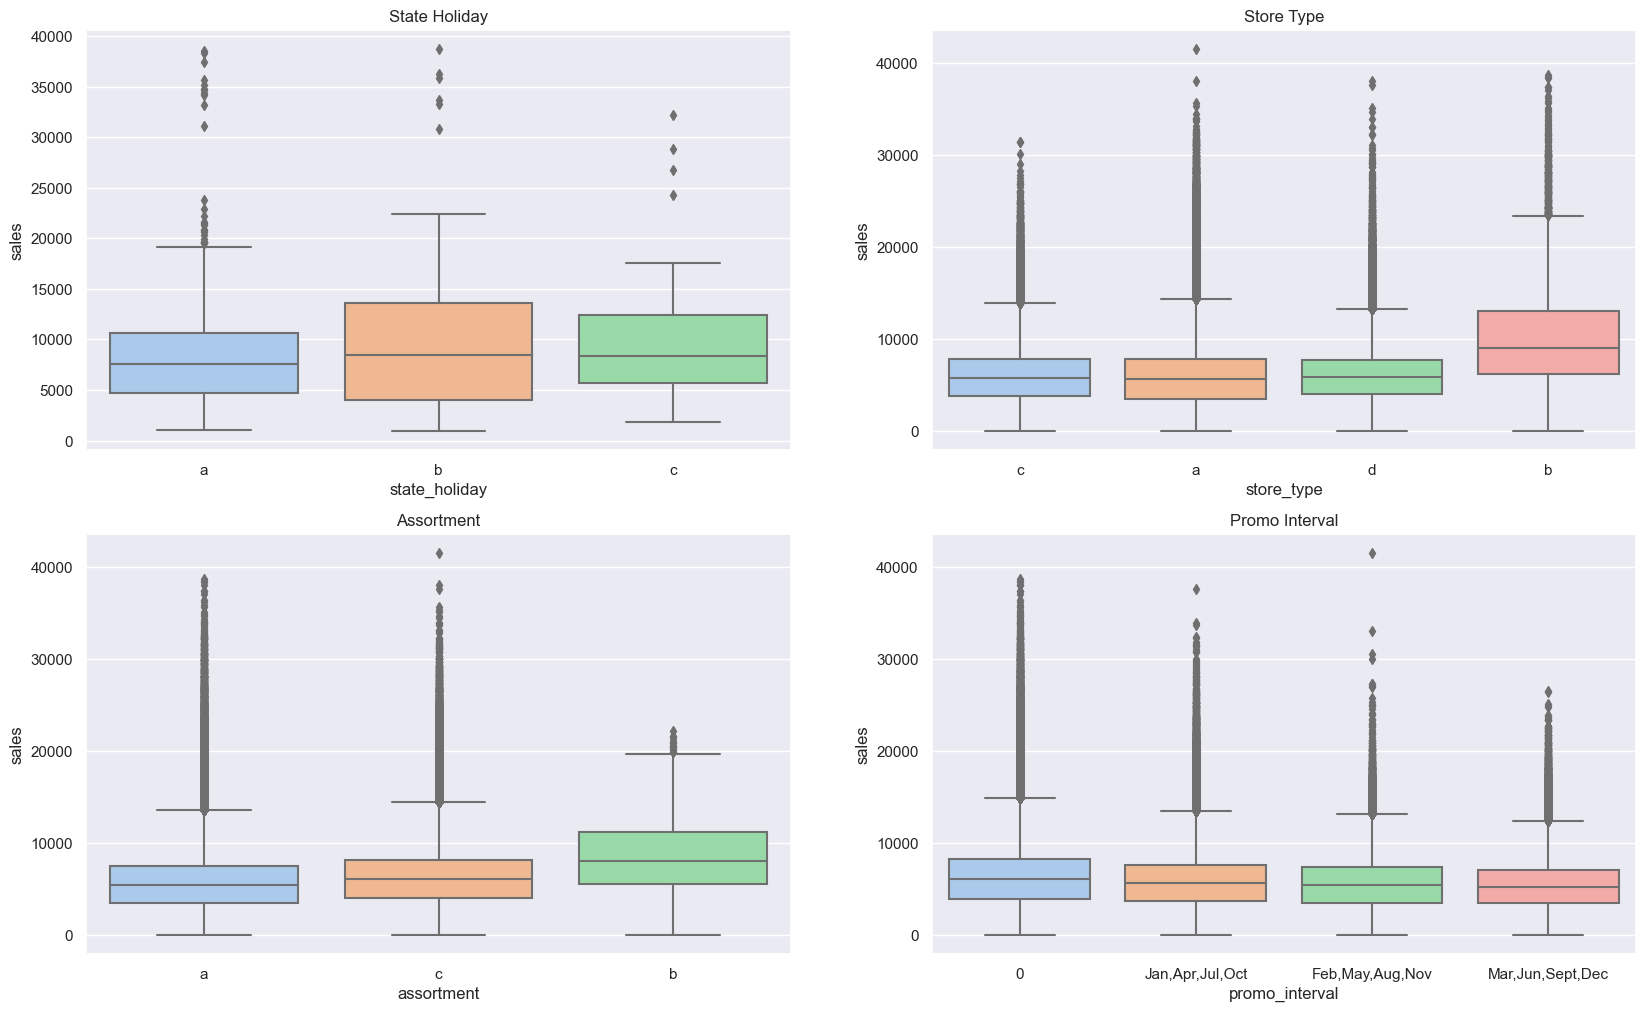

In [16]:
# Set figure size
plt.figure(figsize=(20, 12))

# Filters
aux1 = df1.loc[((df1['sales'] > 0) & (df1['state_holiday'] != '0')), :]

# State Holiday
plt.subplot(2, 2, 1)
ax1 = sns.boxplot(x='state_holiday', y='sales', data=aux1)
ax1.set_title('State Holiday')

# Store Type
plt.subplot(2, 2, 2)
ax2 = sns.boxplot(x='store_type', y='sales', data=df1)
ax2.set_title('Store Type')

# Assortment
plt.subplot(2, 2, 3)
ax3 = sns.boxplot(x='assortment', y='sales', data=df1)
ax3.set_title('Assortment')

# Promo Interval
plt.subplot(2, 2, 4)
ax4 = sns.boxplot(x='promo_interval', y='sales', data=df1)
ax4.set_title('Promo Interval')

plt.show()

# 2. FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

## 2.1 Hypothesis Mindmap

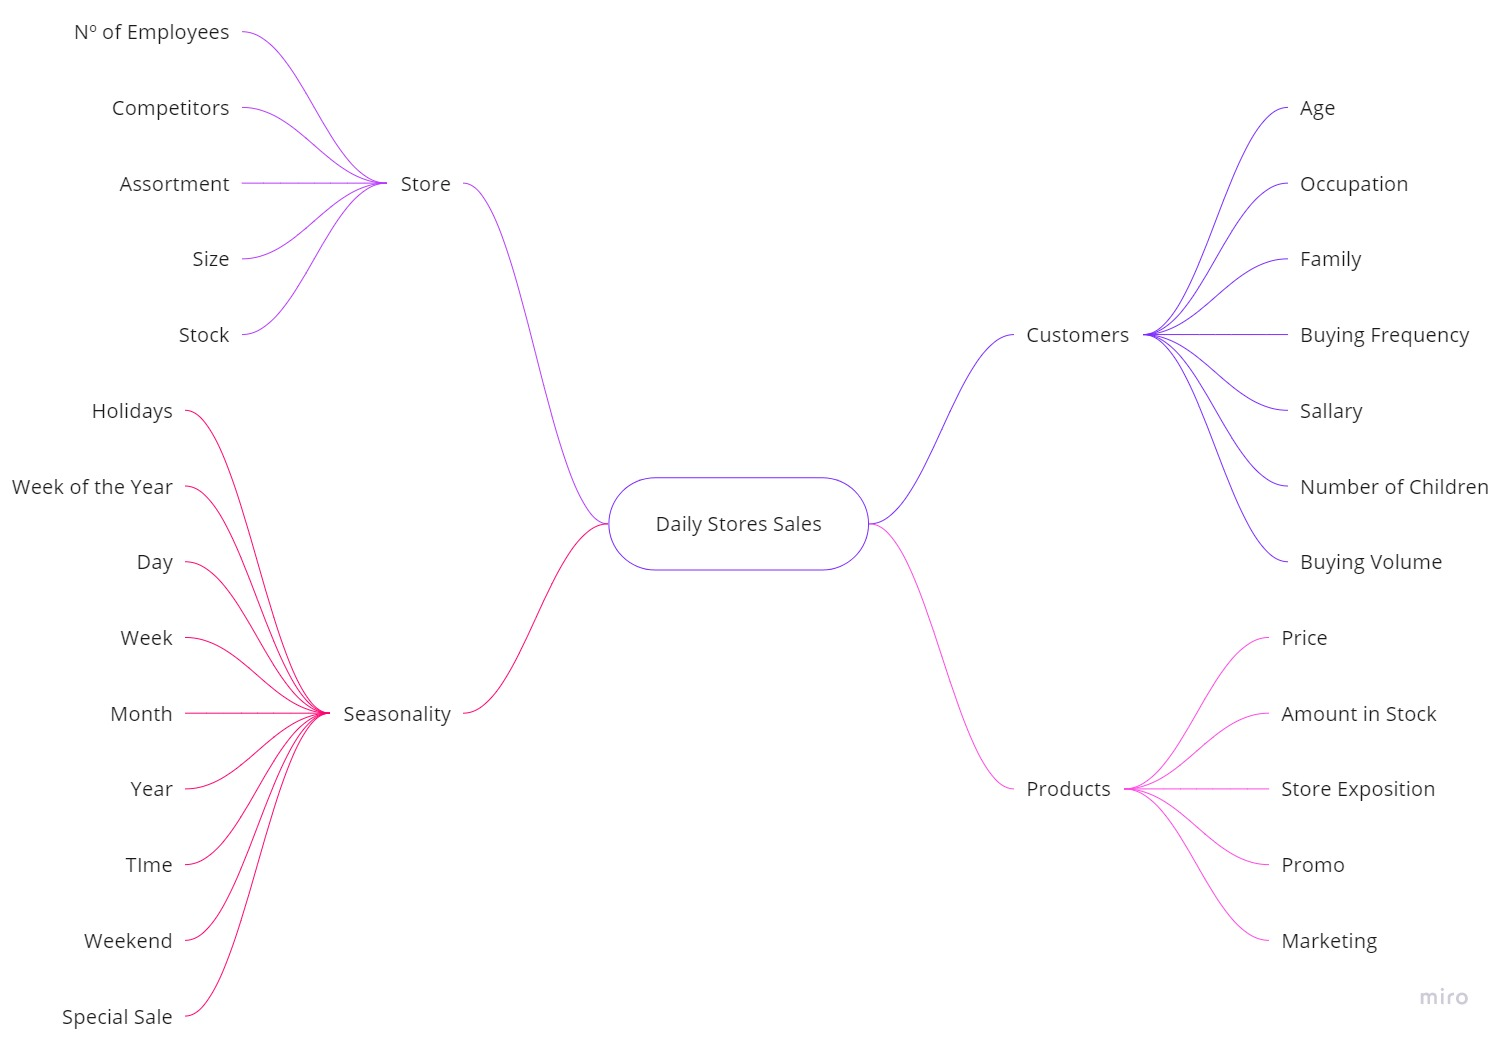

In [18]:
Image('img/mindmap.jpg')

## 2.2 Creating Hypothesis

### 2.2.1 Stores

1. Stores with more employees should sell more.
2. Stores with more stock capacity should sell more.
3. Larger stores should sell more.
4. Stores with a larger assortment should sell more.
5. Stores with closer competitors should sell less.
6. Stores with longer-term competitors should sell more.
7. Stores with more stock capacity should sell more.

### 2.2.2 Products

1. Stores that invest more in marketing should sell more.
2. Stores with more product exposure should sell more.
3. Stores with lower priced products should sell more.
5. Stores with more aggressive promotions (larger discounts) should sell more.
6. Stores with longer promotions should sell more.
7. Stores with more promotion days should sell more.
8. Stores with more consecutive promotions should sell more.

### 2.2.3 Seasonality

1. Stores open during the Christmas holiday should sell more.
2. Stores should sell more over the years.
3. Stores should sell more in the second half of the year.
4. Stores should sell more after the 10th of each month.
5. Stores should sell less on weekends.
6. Stores should sell less during school holidays.days.

## 2.3 Prioritized Hypothesis

1. Stores with a larger assortment should sell more.
2. Stores with closer competitors should sell less.
3. Stores with longer-term competitors should sell more.
4. Stores with longer promotions should sell more.
5. Stores with more promotion days should sell more.
6. Stores with more consecutive promotions should sell more.
7. Stores open during the Christmas holiday should sell more.
8. Stores should sell more over the years.
9. Stores should sell more in the second half of the year.
10. Stores should sell more after the 10th day of each month.
11. Stores should sell less on weekends.
12. Stores should sell less during school holidays.

## 2.4 Feature Engineering

In [19]:
# year
df2['year'] = df1['date'].dt.year

# month
df2['month'] = df1['date'].dt.month

# week
df2['week'] = df1['date'].dt.isocalendar().week

# day
df2['day'] = df1['date'].dt.day

# year-week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Competition since date
df2['competition_since_date'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                                                 month=x['competition_open_since_month'], 
                                                                 day=1), axis=1)

# Number of months in competition
df2['competition_number_months'] = (((df2['date'] - df2['competition_since_date']).dt.days)/30).astype(int)

# Promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# Number of weeks in promo
df2['promo_number_weeks'] = (((df2['date'] - df2['promo_since']).dt.days)/7).astype(int)

# Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x== 'b' else 'extended')

# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                            'easter_holiday' if x == 'b' else 
                                                            'christmas' if x == 'c' else 
                                                            'no_holiday')

# 3 FEATURE FILTERING

In [20]:
df3 = df2.copy()

## 3.1 Columsn Description

- **store** - a unique Id for each store
- **day_of_week** - The ordinal day of week
- **date** - The date of the register (YYYY-MM-DD)
- **sales** - the turnover for any given day (this is what you are predicting)
- **customers** - the number of customers on a given day
- **open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **promo** - indicates whether a store is running a promo on that dayPromo
- **state_holiday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.  Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **school_holiday** - indicates if the (Store, Date) was affected by the closure of public schools
- **store_type** - differentiates between 4 different store models: a, b, c, d
- **assorment** - describes an assortment level: a = basic, b = extra, c = extended
- **competition_distance** - distance in meters to the nearest competitor store
- **competition_open_since_month** - The number of the month in which since there's a competition running for that store
- **competition_open_since_year** - The number of the year in which since there's a competition running for that store
- **promo2** - Promo2 is a continuing and consecutive promotion for some stores:  0 = store is not participating, 1 = store is participating
- **promo2_since_week** - The number of the week of the year since the promo2 is running
- **promo2_since_year** - The number of the year since promo2 is running
- **promo_interval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.
- **month_map** - The month name of the date
- **is_promo** - Flags if whether the current month is in promo interval. When it is, we can interpretate that promo2 is active on that date
- **year, month, week, day** - The derivated time granularity of each date**
- **year_week**- The week of the year and the year
- **competition_since_date** - The date of since when there's a competition (YYYY-MM-DD)
- **'competition_number_month** - The number of months of since there's a near competitor to that store
- **'promo_sice** - The date of since there's a second promo on that store
- **'promo_number_week** - The number of weeks since there's a second promo on that store


## 3.2 Rows Filtering

In [21]:
# Rows before filtering
len(df3)

1017209

In [22]:
conditions = (df3['open'] != 0) & (df3['sales'] > 0)
df3 = df3[conditions].reset_index(drop=True)

In [23]:
# Rows after filtering
len(df3)

844338

## 3.3 Columns Selection

In [24]:
cols = ['customers', 'open', 'month_map', 'promo_interval']
df3.drop(columns=cols, axis=1, inplace=True)

In [25]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,week,day,year_week,competition_since_date,competition_number_months,promo_since,promo_number_weeks
0,1,5,2015-07-31,5263,1,no_holiday,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,no_holiday,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,no_holiday,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,no_holiday,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,no_holiday,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4. EXPLORATORY DATA ANALYSIS (EDA)

In [26]:
df4 = df3.copy()

## 4.1 Univariate Analysis

In [27]:
# sales mean
np.mean(df4['sales'])

6955.959133664481

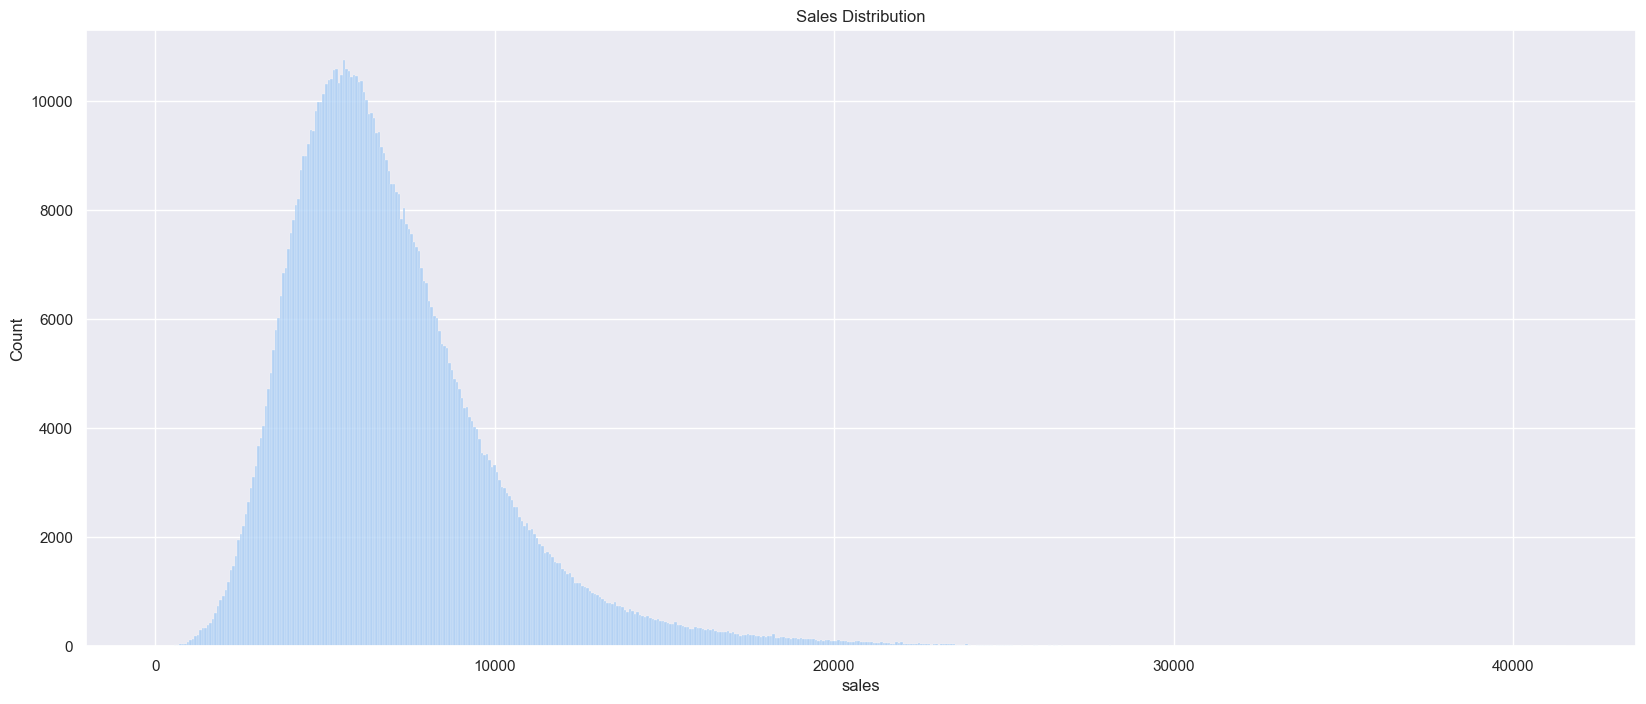

In [28]:
# Plot sales distribution
ax1 = sns.histplot(df4['sales'], legend=True)
ax1.set_title('Sales Distribution')
plt.show()

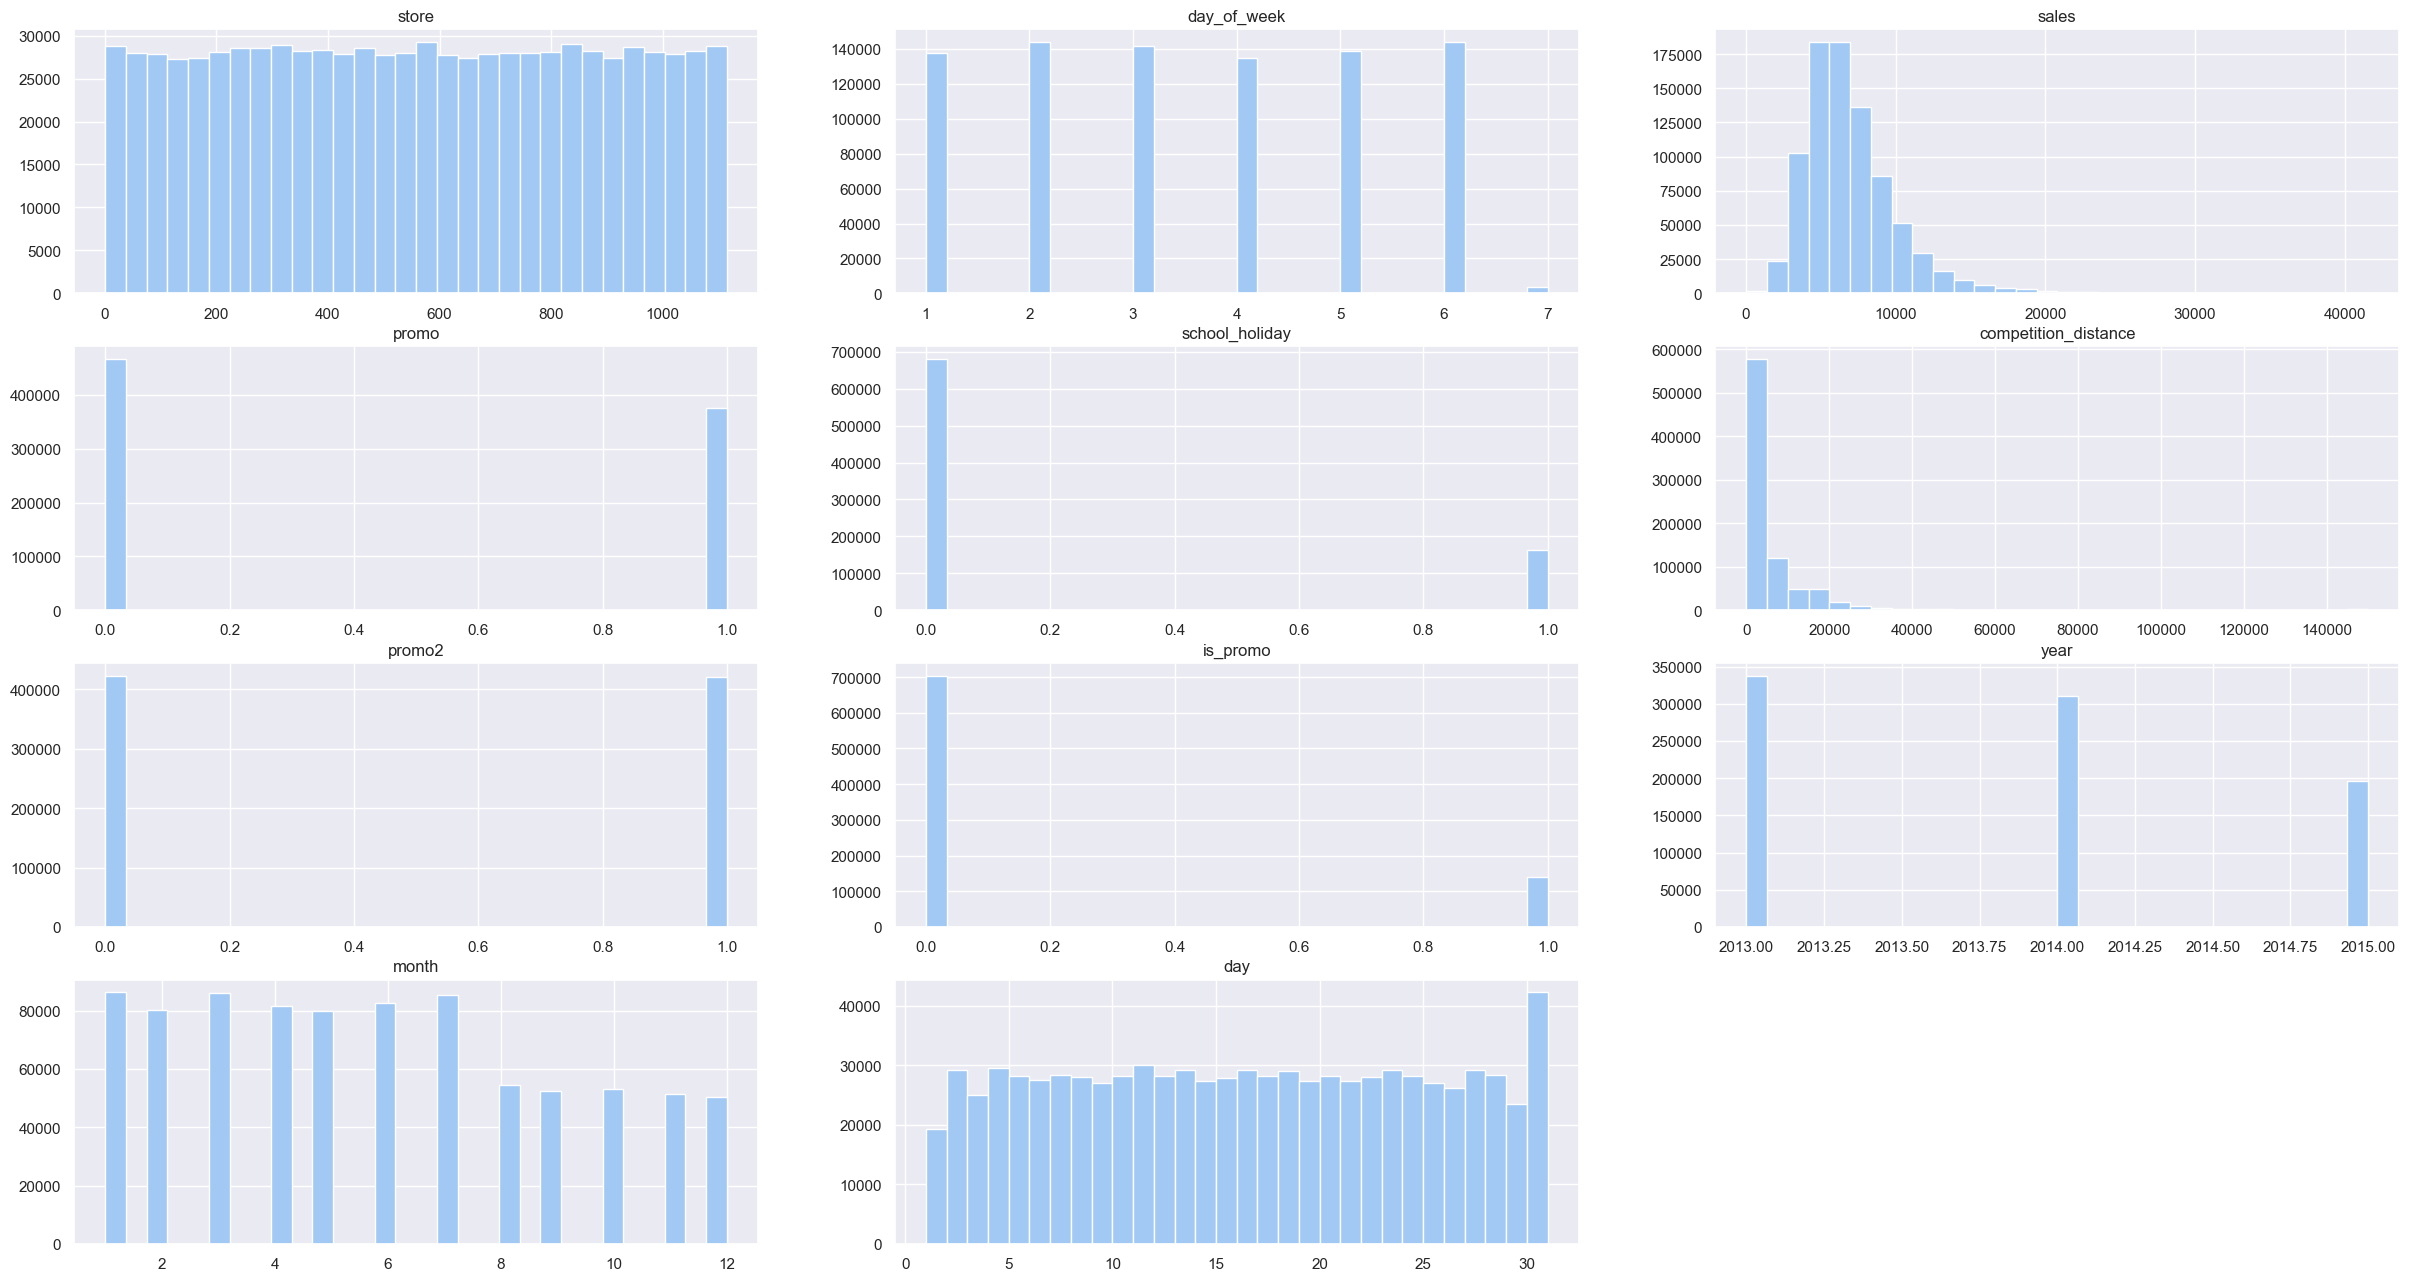

In [29]:
# Plot numerical attributes
num_att = df4.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(30, 24))

cols = num_att.columns.to_list()

for i in range(0, len(cols)):
    ax = plt.subplot(6, 3, i+1)
    ax.set_title(cols[i])

    num_att[cols[i]].hist(bins=30)

plt.show()

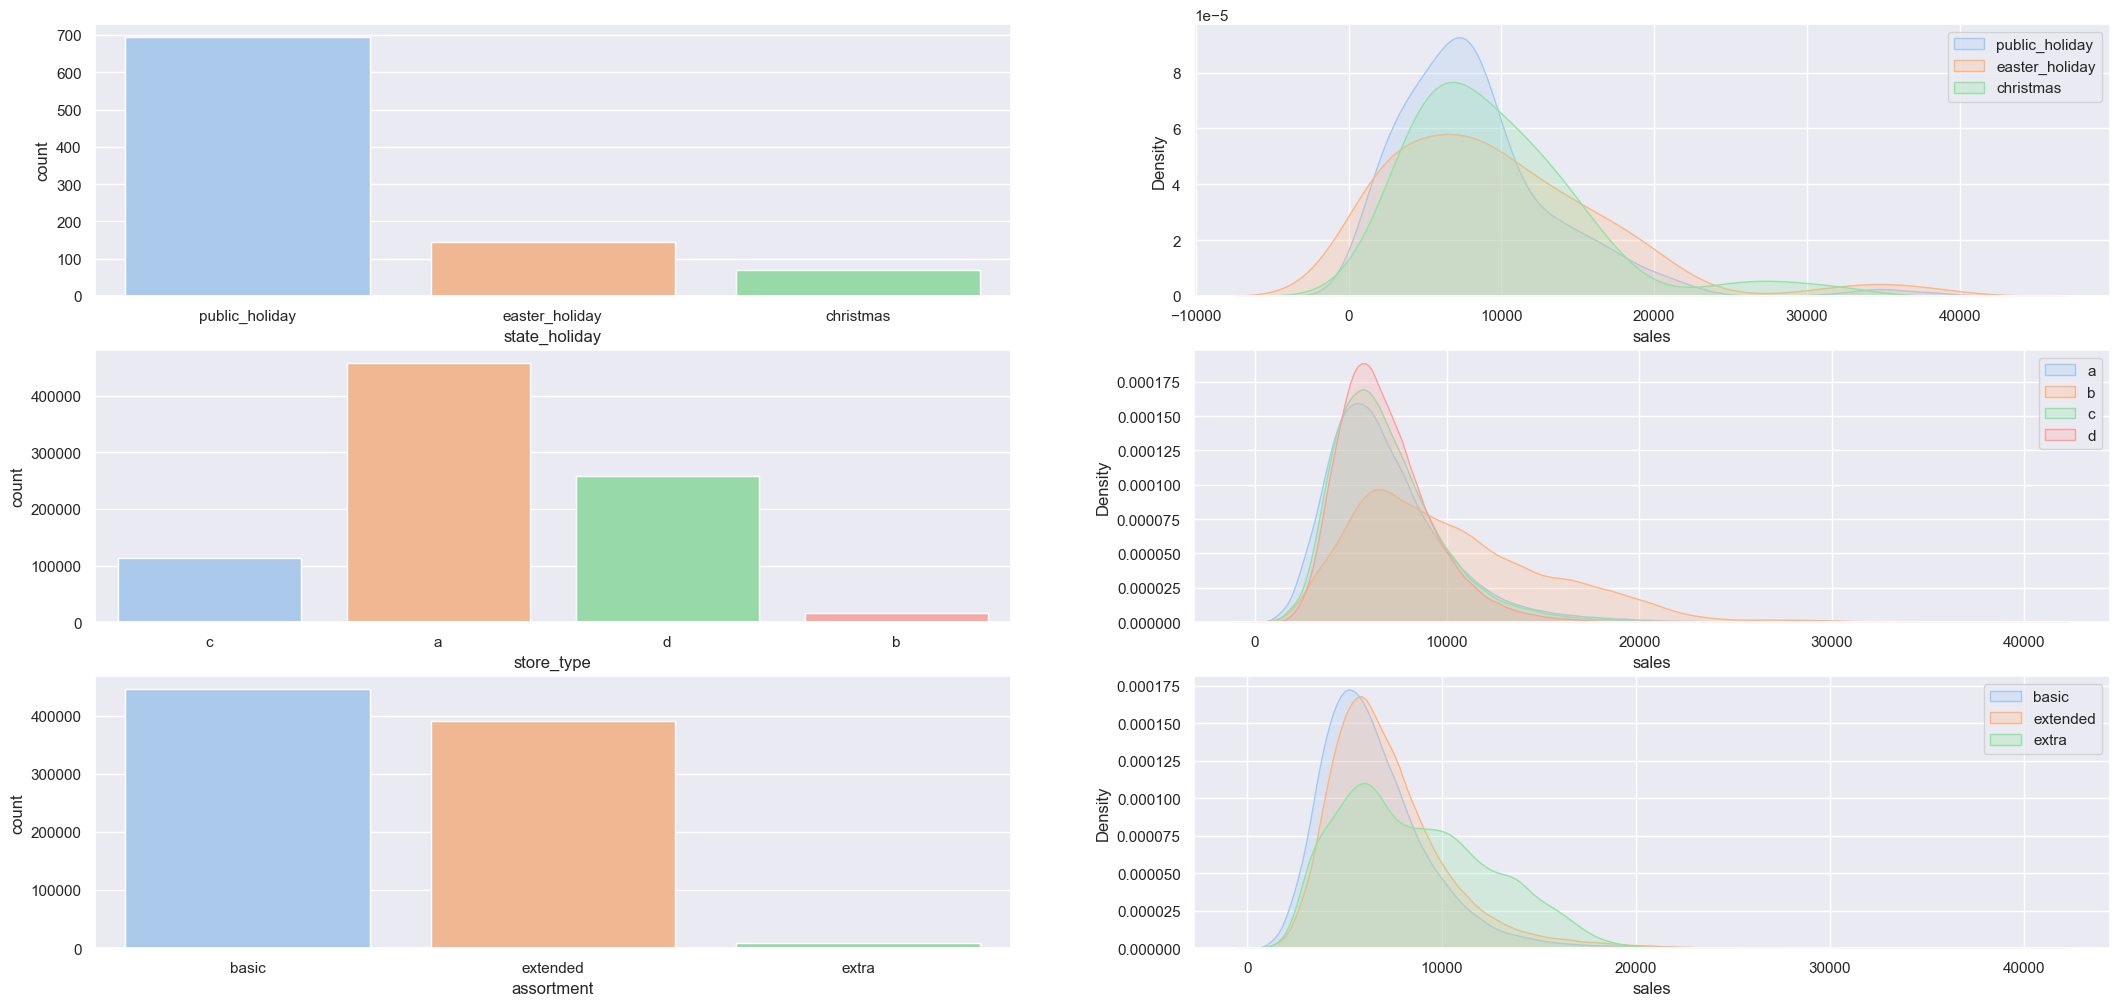

In [30]:
# Plot categorical attibutes vs sales
plt.figure(figsize=(26, 12))

# State holiday
a = df4[df4['state_holiday'] != 'no_holiday']

plt.subplot(3, 2, 1)
sns.countplot(x=a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.legend(labels=['public_holiday', 'easter_holiday', 'christmas'])

# Store type
plt.subplot(3, 2, 3)
sns.countplot(x= df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
plt.legend(labels=['a', 'b', 'c', 'd'])

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(x= df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)
plt.legend(labels=['basic', 'extended', 'extra']);

## 4.2 Bivariate Analysis

### H1 - Stores with a larger assortment should sell more 
**(FALSE)** - Basic and extended assortment represent as bigger amount of sales. Throughout time, the behavior kept very stable

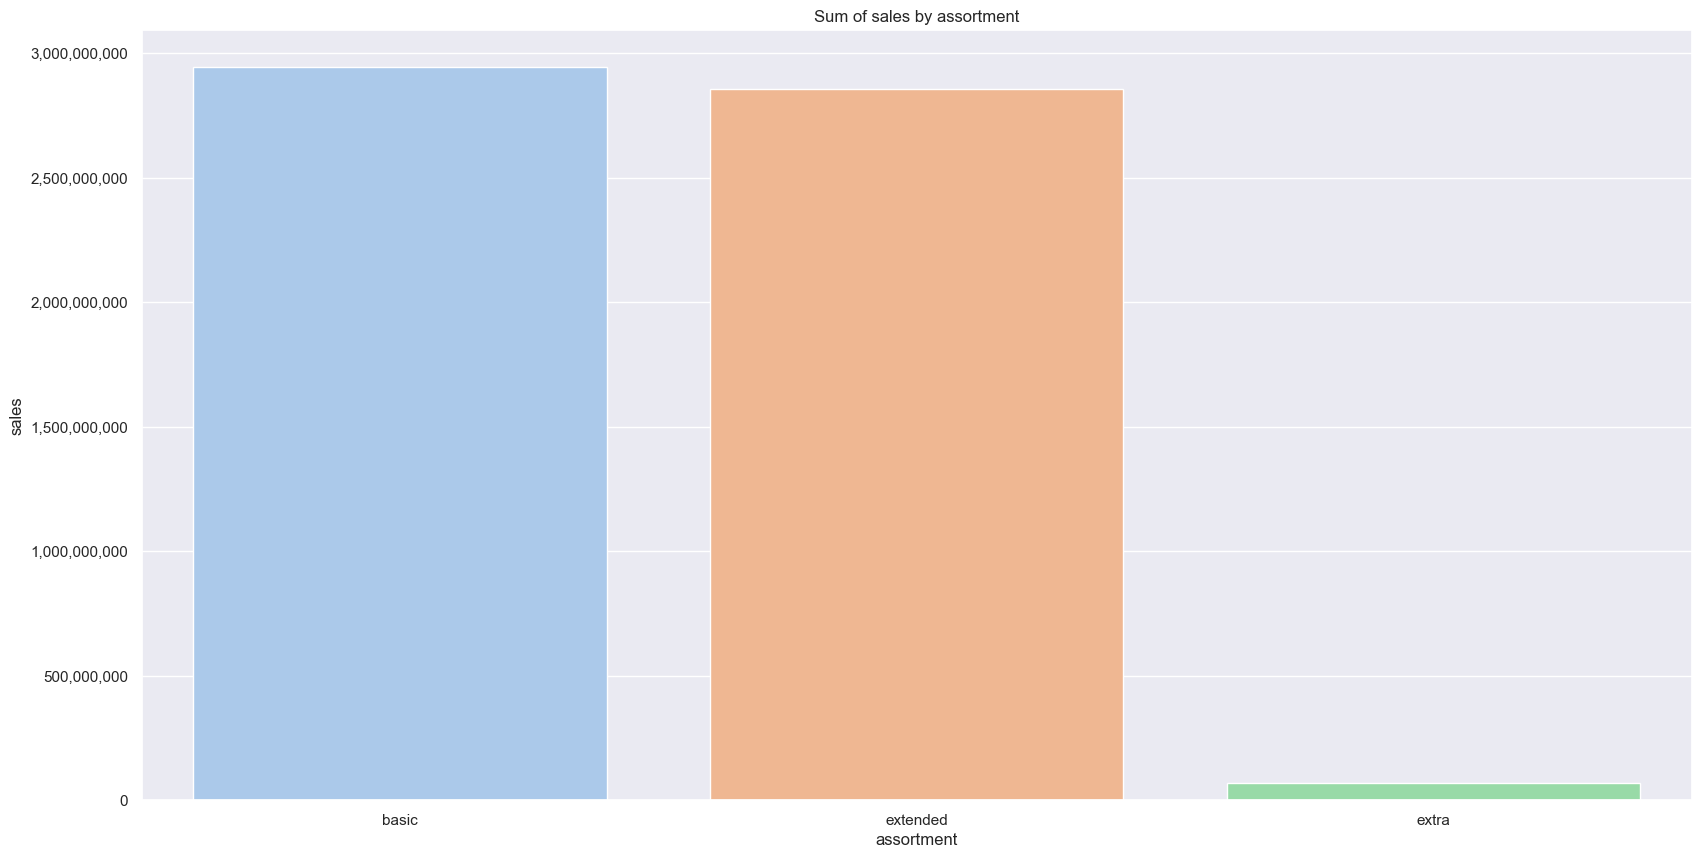

In [31]:
plt.figure(figsize=(20, 10))

# bar plot of sales by assortment
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

ax1 = sns.barplot(data=aux1, x='assortment', y='sales')
ax1.set_title('Sum of sales by assortment')

plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

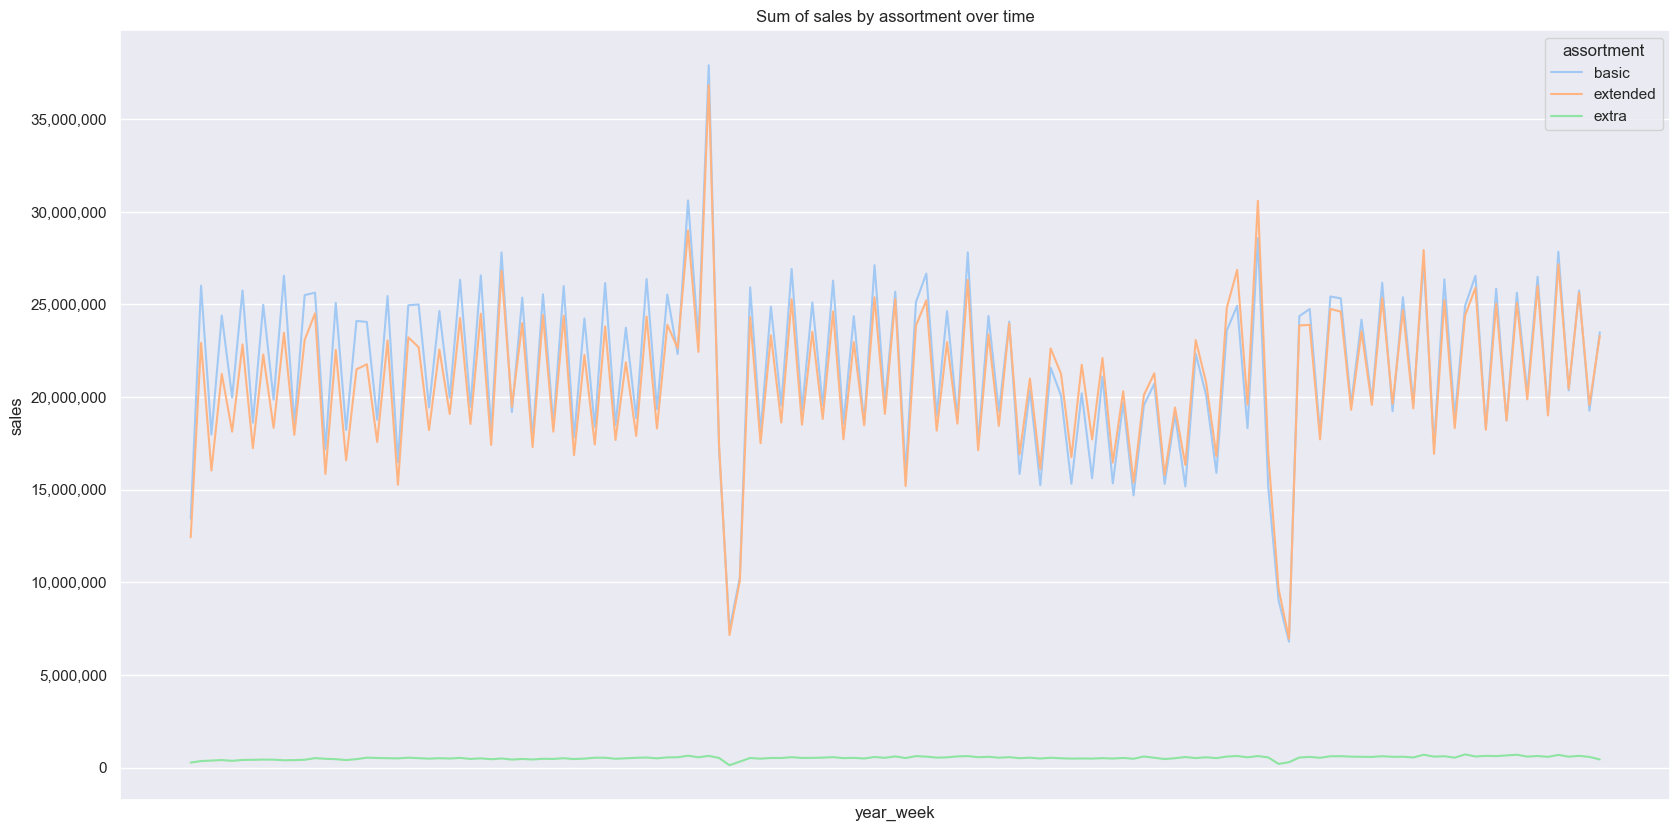

In [32]:
plt.figure(figsize=(20, 10))

# time series of sales by assortment over time
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

ax2 = sns.lineplot(data=aux2, x='year_week', y='sales', hue='assortment')
ax2.set_title('Sum of sales by assortment over time')

plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks([])
plt.show()

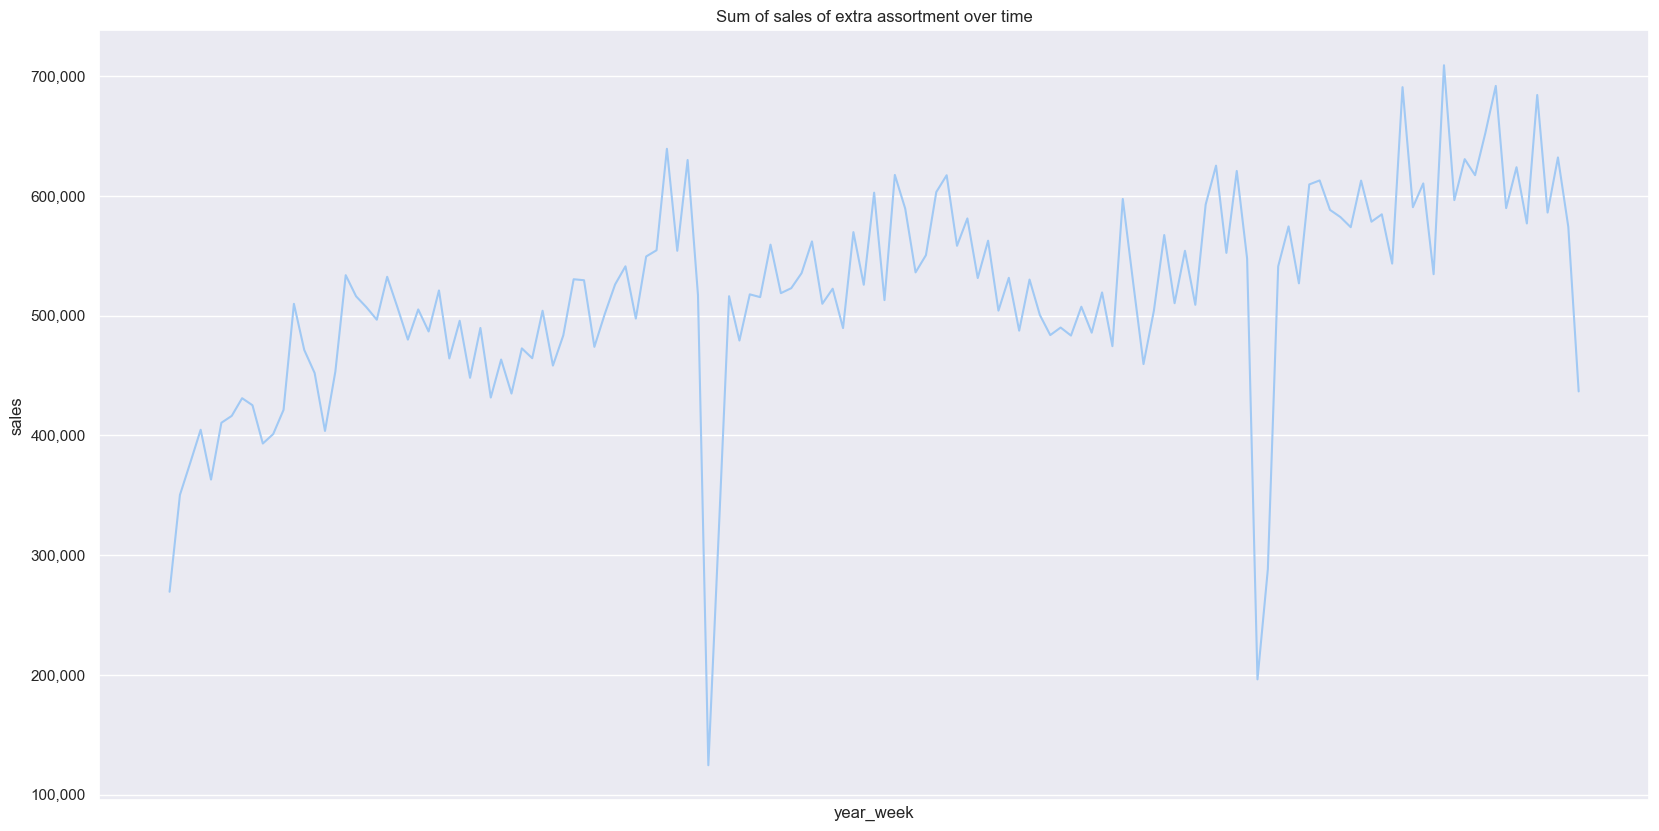

In [33]:
plt.figure(figsize=(20, 10))

# time series of extra assortment sales over time
aux3 = df4.loc[df4['assortment'] == 'extra', :]
aux3 = aux3[['year_week', 'sales']].groupby('year_week').sum().reset_index()

ax3 = sns.lineplot(data=aux3, x='year_week', y='sales')
ax3.set_title('Sum of sales of extra assortment over time')

plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks([])
plt.show()

### H2. Stores with closer competitors should sell less 
**(FALSE)** - Stores with closer competitors sells more in volume if compared with stores with distant competitors.

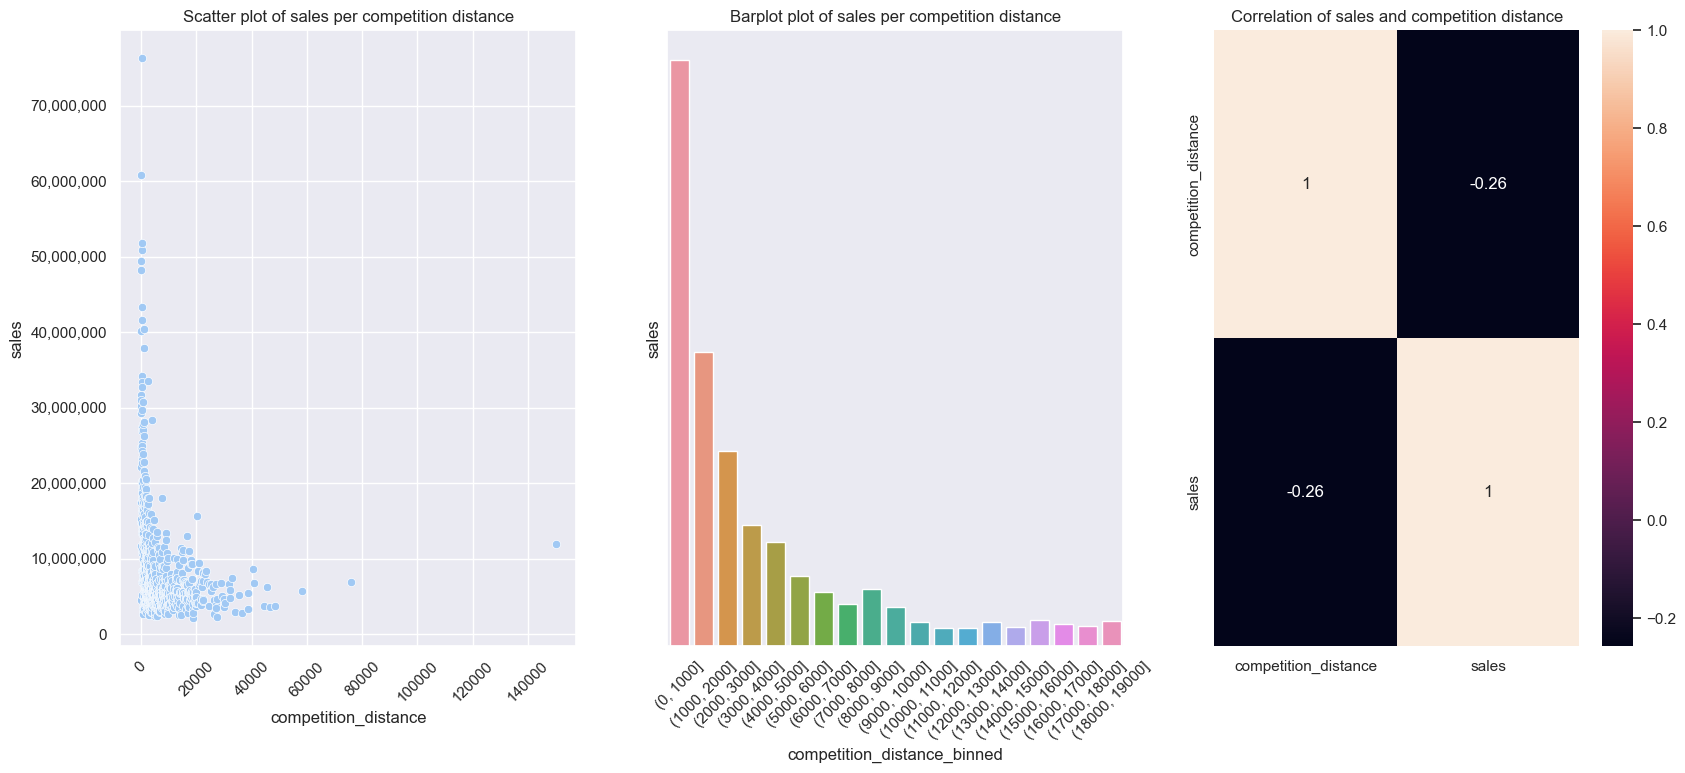

In [34]:
aux1 = df4[['sales', 'competition_distance']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
ax1 = sns.scatterplot(data=aux1, x='competition_distance', y='sales')
ax1.set_title('Scatter plot of sales per competition distance')
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], list(range(0, 20000, 1000)))
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
ax2 = sns.barplot(data=aux2, x='competition_distance_binned', y='sales')
ax2.set_title('Barplot plot of sales per competition distance')
plt.yticks([])
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
ax3 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax3.set_title('Correlation of sales and competition distance')

plt.show()

### H3. Stores with longer-term competitors should sell more. 
**(FALSE)** - As competition time increases, the sales volume decreases

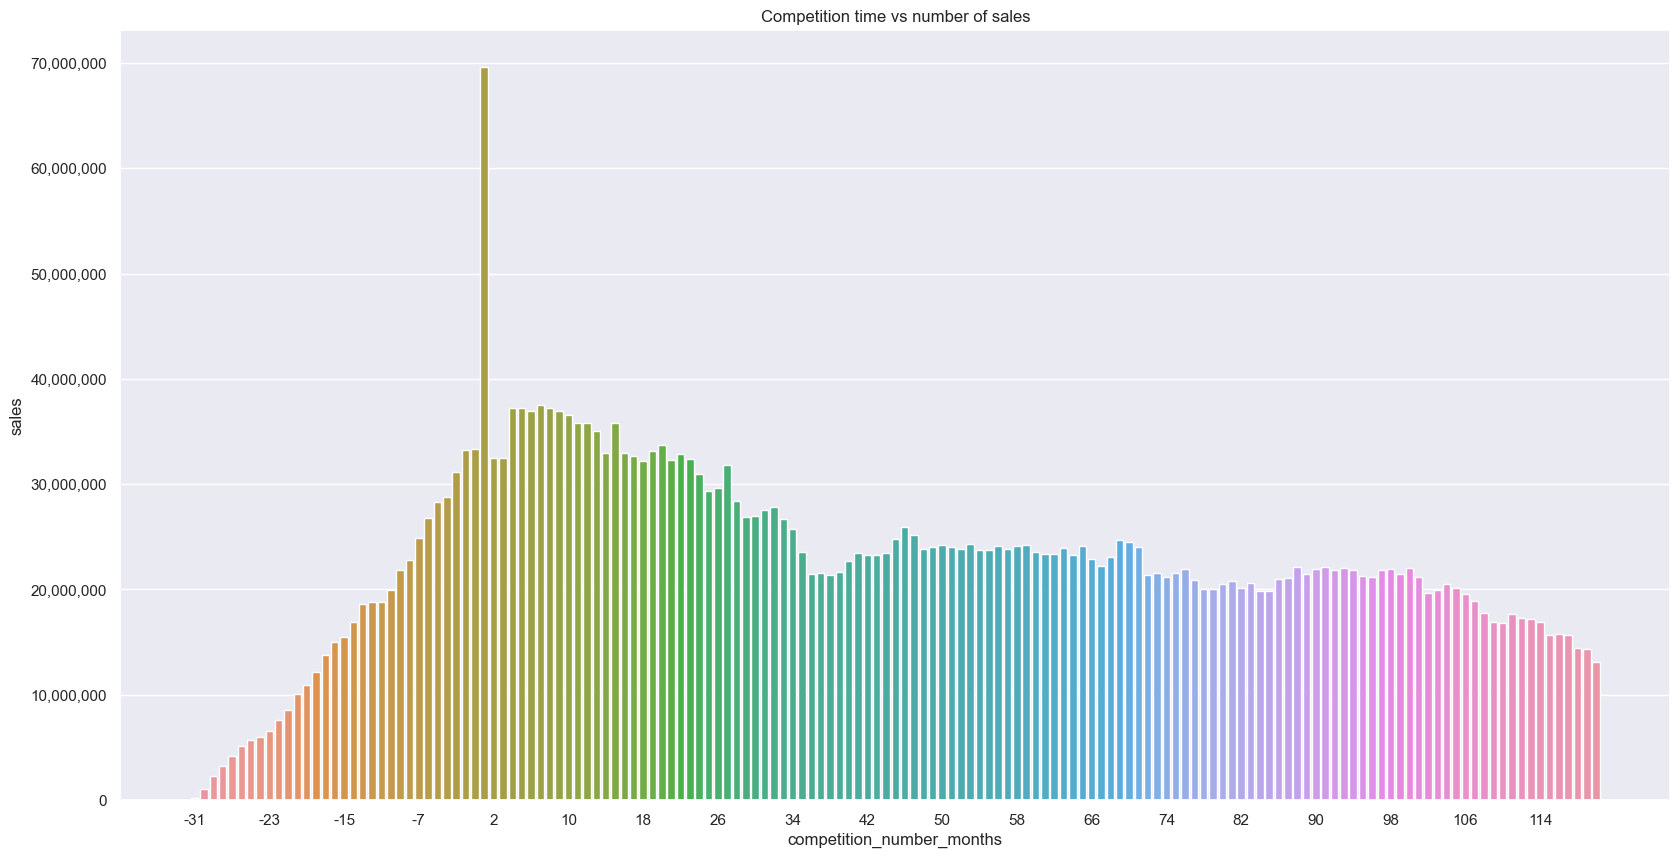

In [35]:
plt.figure(figsize=(20, 10))

min_competition = df4['competition_number_months'].min()
max_competition = 120

filter = (df4['competition_number_months'] >= min_competition) & (df4['competition_number_months'] <= max_competition) & (df4['competition_number_months'] != 0)
aux1 = df4.loc[filter, :][['competition_number_months', 'sales']].groupby('competition_number_months').sum().reset_index()
aux2 = df4[['competition_number_months', 'sales']].groupby('competition_number_months').sum().reset_index()

ax1 = sns.barplot(data=aux1, x='competition_number_months', y='sales')
ax1.set_title('Competition time vs number of sales')
ax1.locator_params(axis='x', nbins=20)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

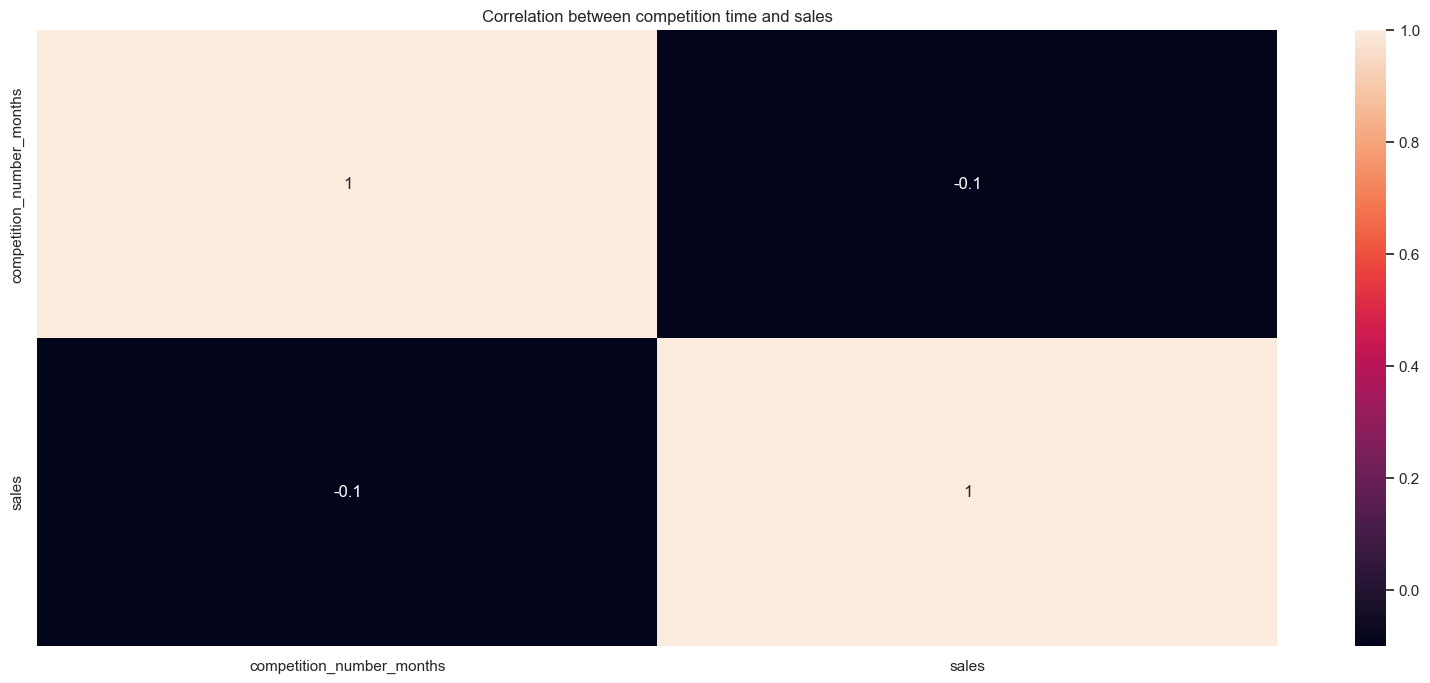

In [36]:
ax2 = sns.heatmap(aux2.corr(method='pearson'), annot=True)
ax2.set_title('Correlation between competition time and sales')
plt.show()

### H4. Stores with longer promotions should sell more 
**(FALSE)** - Store with extended promotions tend to less over time.

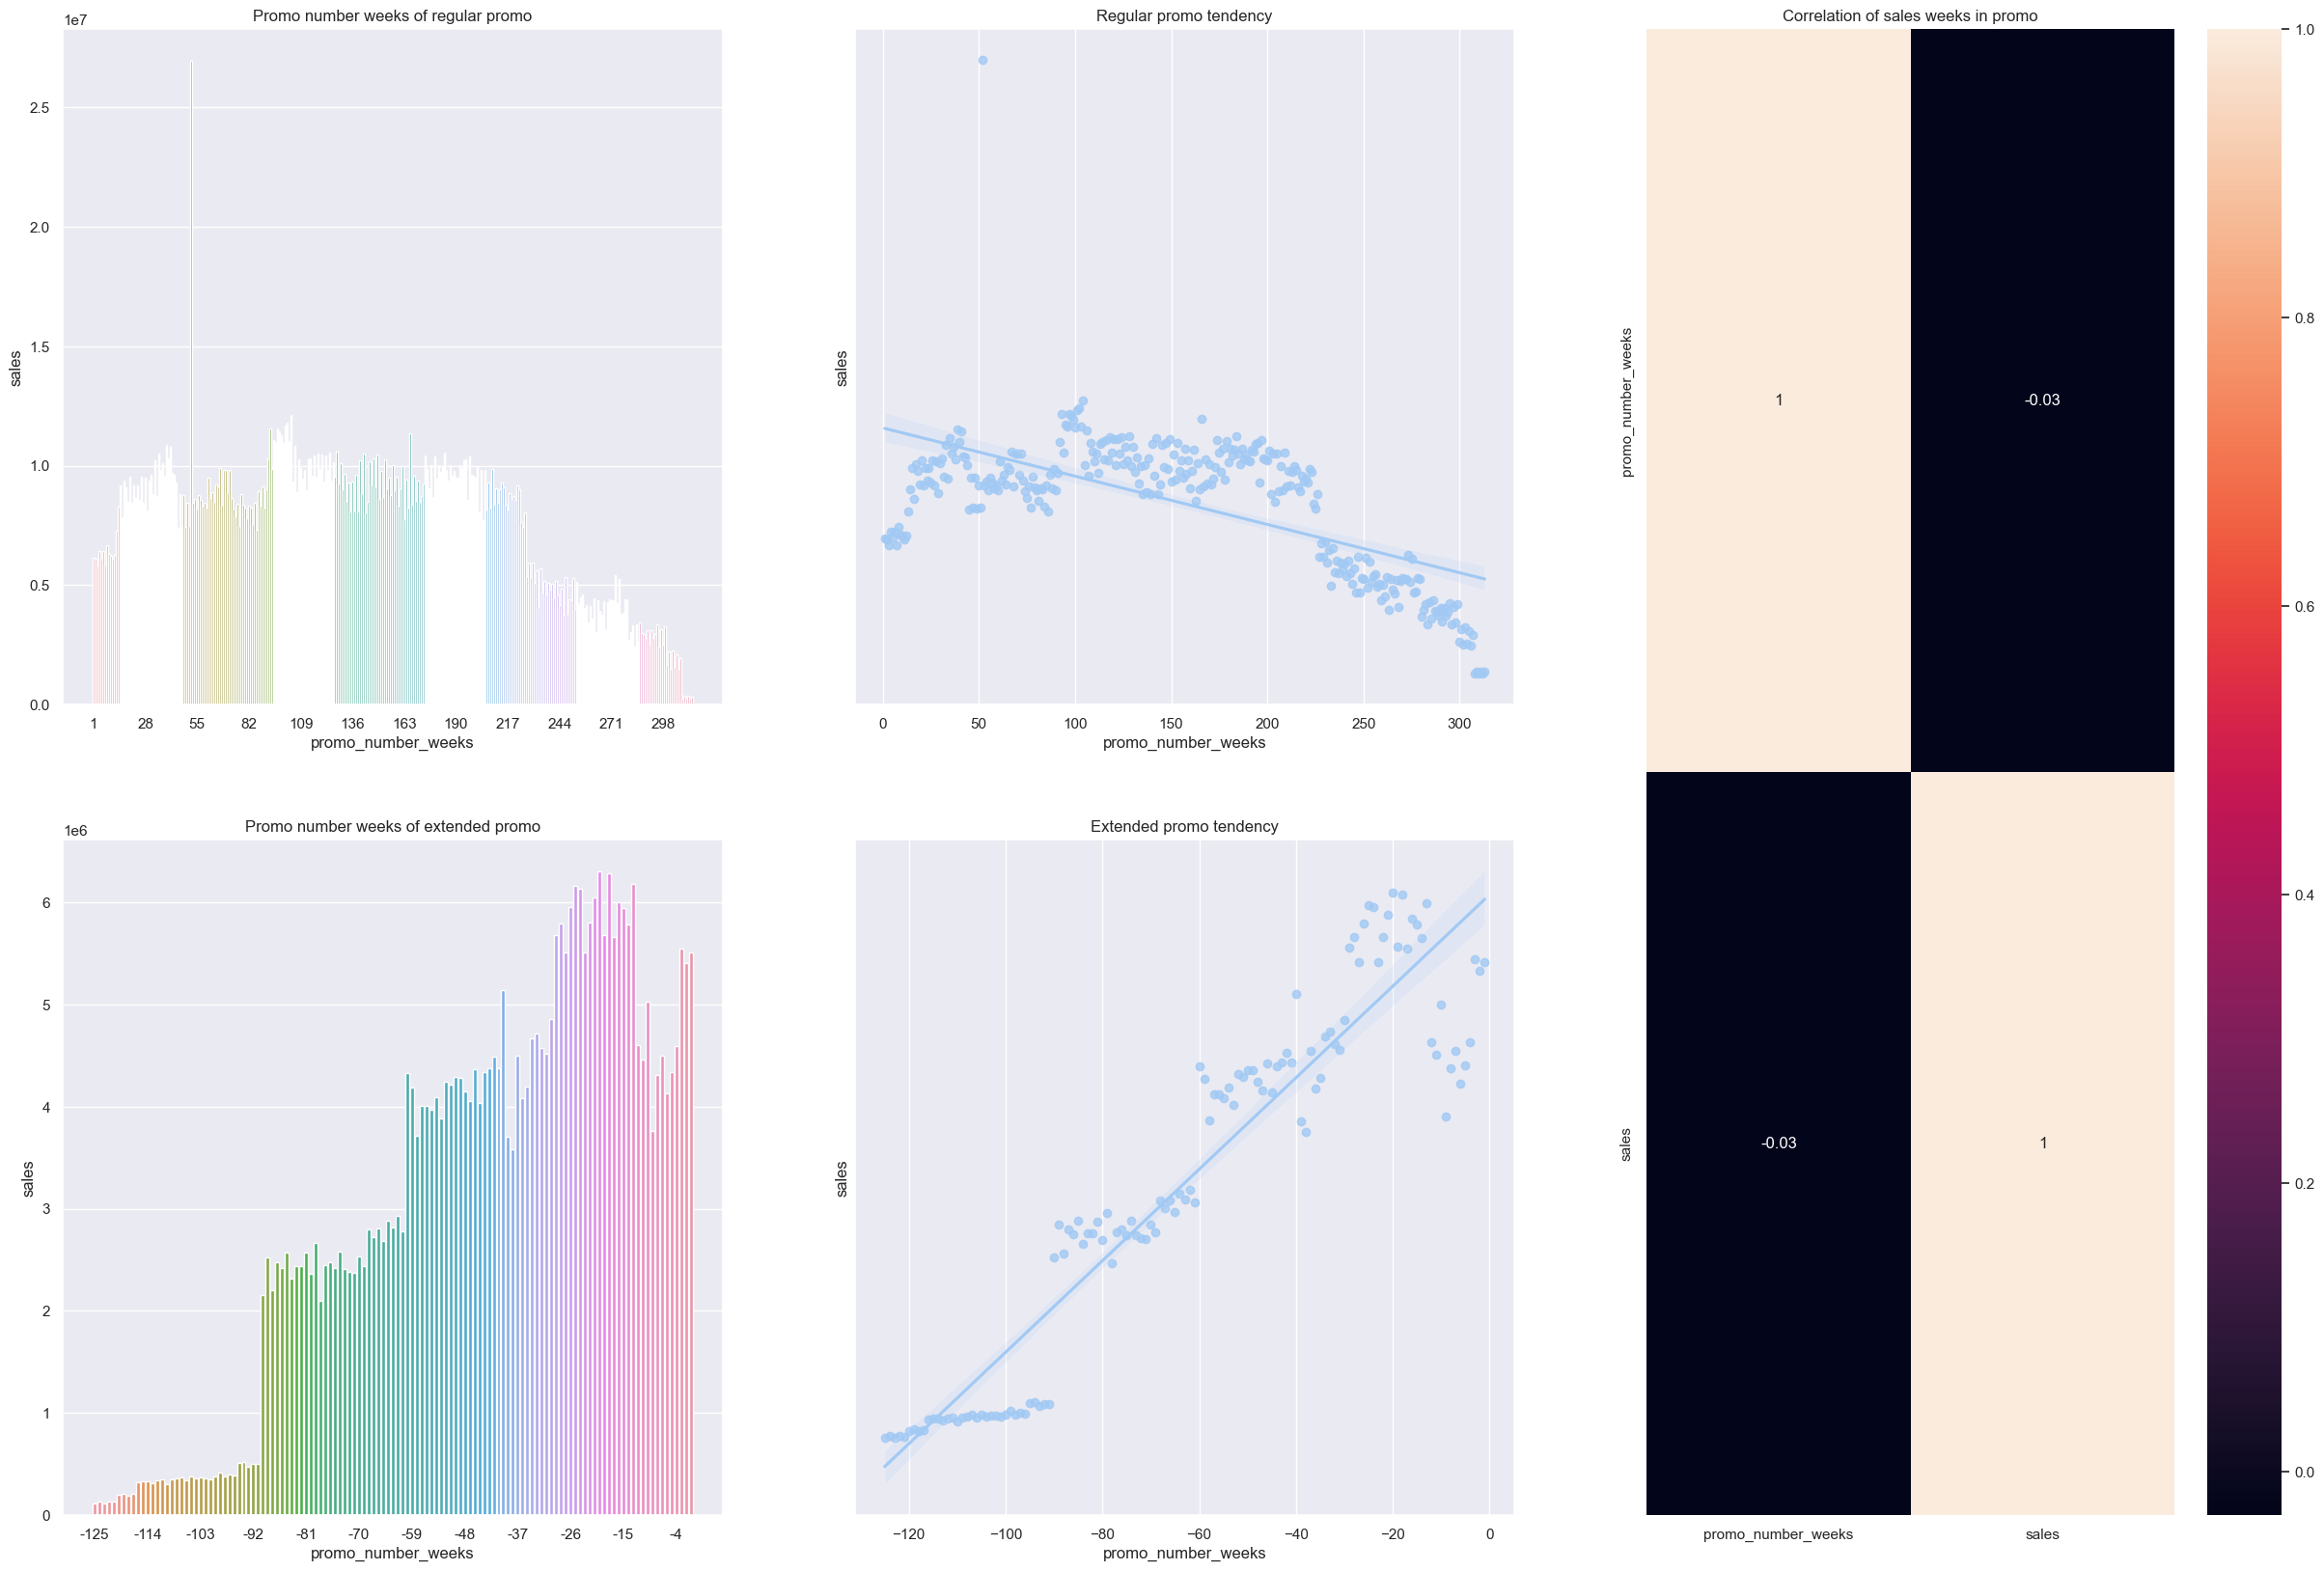

In [37]:
plt.figure(figsize=(30, 20))

aux1 = df4[['sales', 'promo_number_weeks']].groupby('promo_number_weeks').sum().reset_index()
aux3 = aux1[aux1['promo_number_weeks'] > 0] # extended (promo)
aux2 = aux1[aux1['promo_number_weeks'] < 0] # regular (promo2)

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
ax1 = sns.barplot(data=aux3, x='promo_number_weeks', y='sales')
ax1.set_title('Promo number weeks of regular promo')
ax1.locator_params(axis='x', nbins=12)

plt.subplot(grid[0, 1])
ax2 = sns.regplot(data=aux3, x='promo_number_weeks', y='sales')
ax2.set_title('Regular promo tendency')
plt.yticks([])

plt.subplot(grid[1, 0])
ax3 = sns.barplot(data=aux2, x='promo_number_weeks', y='sales')
ax3.set_title('Promo number weeks of extended promo')
ax3.locator_params(axis='x', nbins=12)

plt.subplot(grid[1, 1])
ax4 = sns.regplot(data=aux2, x='promo_number_weeks', y='sales')
ax4.set_title('Extended promo tendency')
plt.yticks([])

plt.subplot(grid[:, 2])
ax5 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax5.set_title('Correlation of sales weeks in promo')

plt.show()

### <s>H5. Stores with more promotion days should sell more.</s>

### H6. Stores with more consecutive promotions should sell more 
(**FALSE**) - Stores with shorter promotions tend to sell more

In [38]:
aux1 = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales', ascending=False)
aux1

,promo,promo2,sales
2,1,0,1628930532
0,0,0,1482612096
3,1,1,1472275754
1,0,1,1289362241


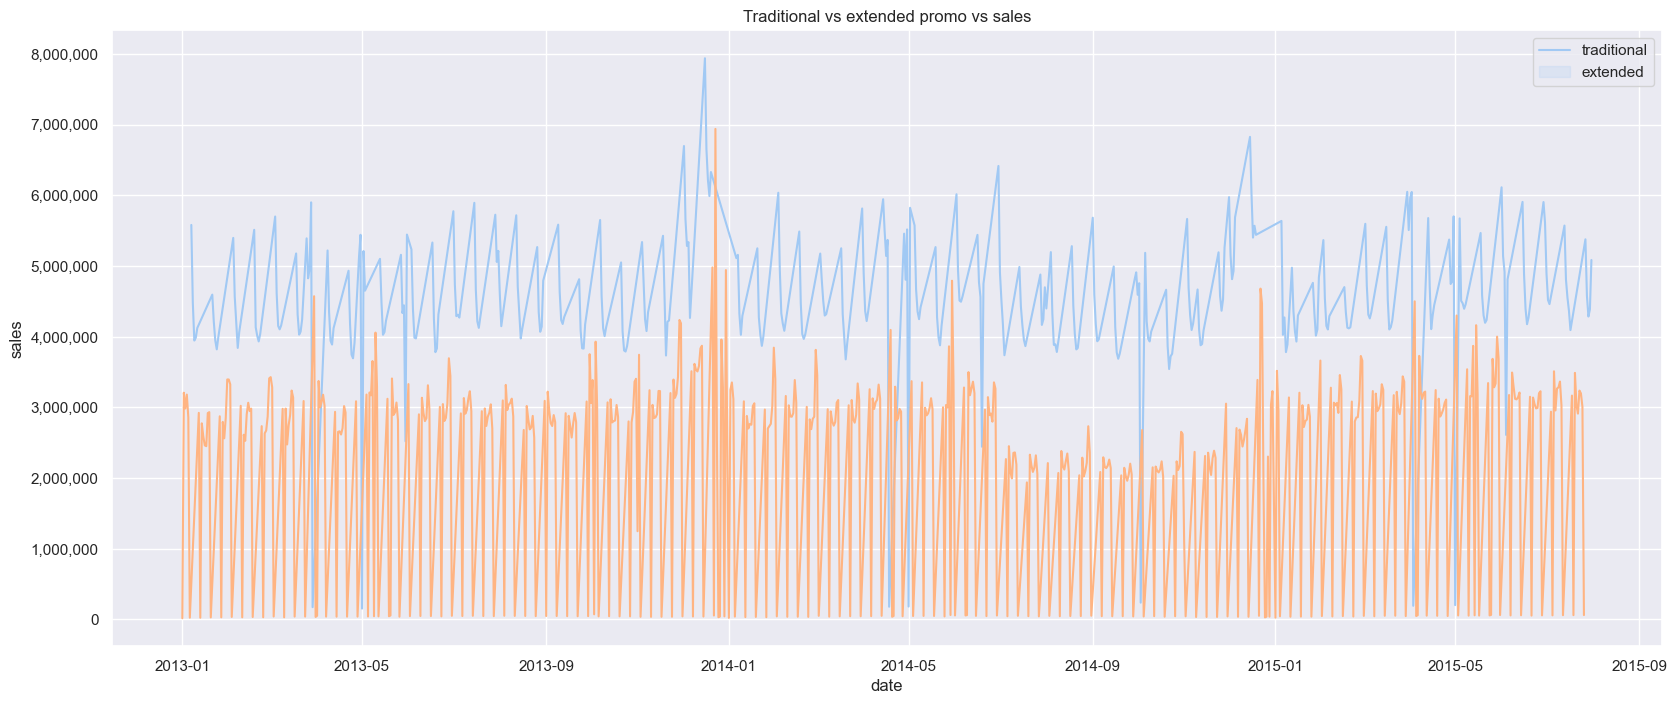

In [39]:
# traditional and extended
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['sales', 'date']].groupby('date').sum().reset_index()
ax = sns.lineplot(data=aux1, x='date', y='sales')

# traditional
aux2 = df4[(df4['promo'] == 0) & (df4['promo2'] == 1)][['sales', 'date']].groupby('date').sum().reset_index()
sns.lineplot(data = aux2, x='date', y='sales', ax=ax)

ax.legend(labels=['traditional', 'extended'])
ax.set_title('Traditional vs extended promo vs sales')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

### H7. Stores open during the Christmas holiday should sell more 
**(FALSE)** - Christmas is the holiday with less sales.

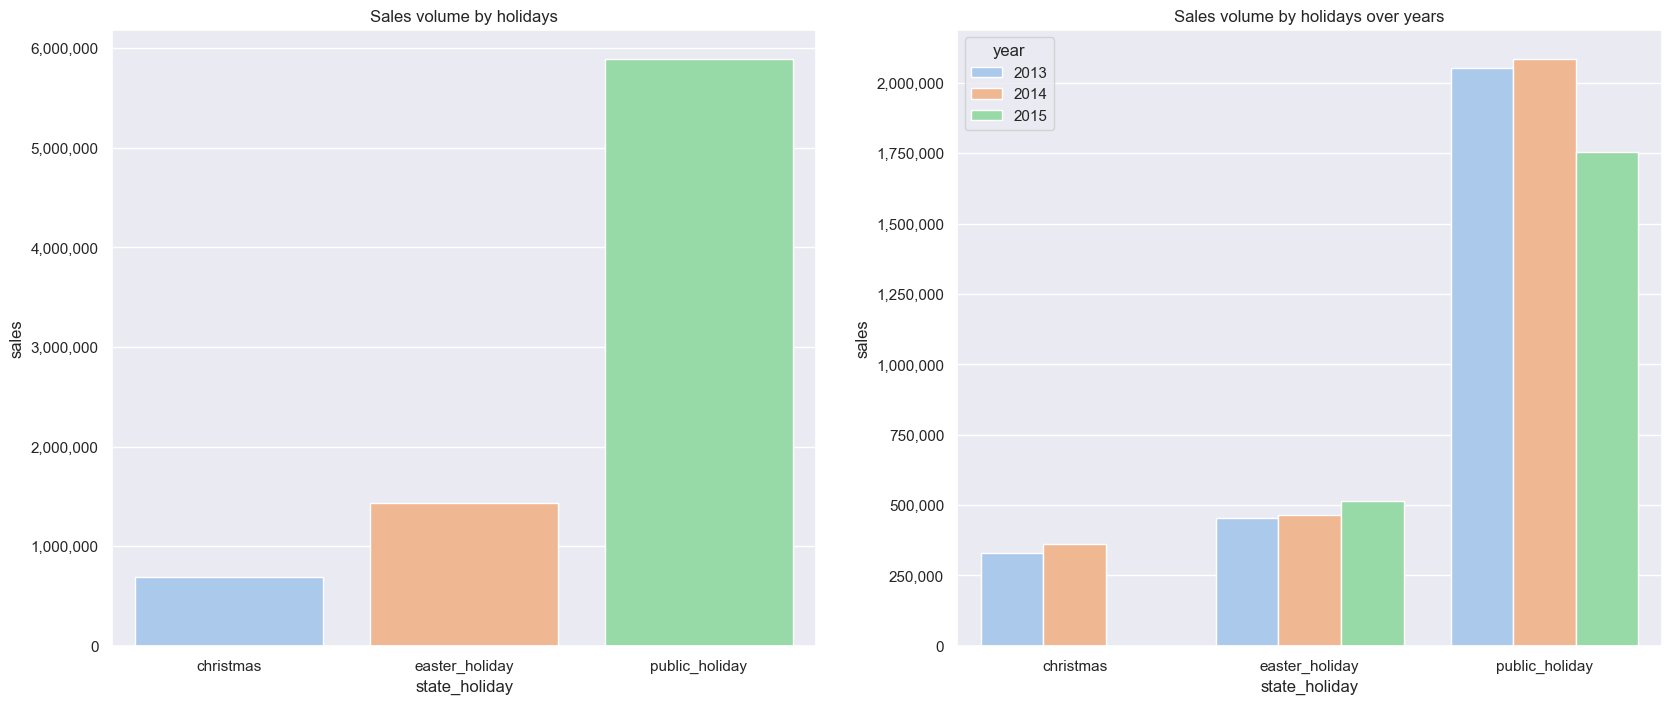

In [40]:
aux1 = df4[df4['state_holiday'] != 'no_holiday'][['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux2 = df4[df4['state_holiday'] != 'no_holiday'][['state_holiday', 'year', 'sales']].groupby(['state_holiday', 'year']).sum().reset_index()

plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=aux1, x='state_holiday', y='sales')
ax1.set_title('Sales volume by holidays')
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=aux2, x='state_holiday', y='sales', hue='year')
ax2.set_title('Sales volume by holidays over years')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

### H8. Stores should sell more over the years 
**(TRUE)** - The average sales increases over years, and also, if we compare the closed period of all the three years.

We have data of three years (2013, 2014 and 2015), but 2015 we had data until jul 31th. Being so, we will analyze from two points of view. We will look at the mean sales volume, and also will look to the sales data ultil jul 31th of the other years.

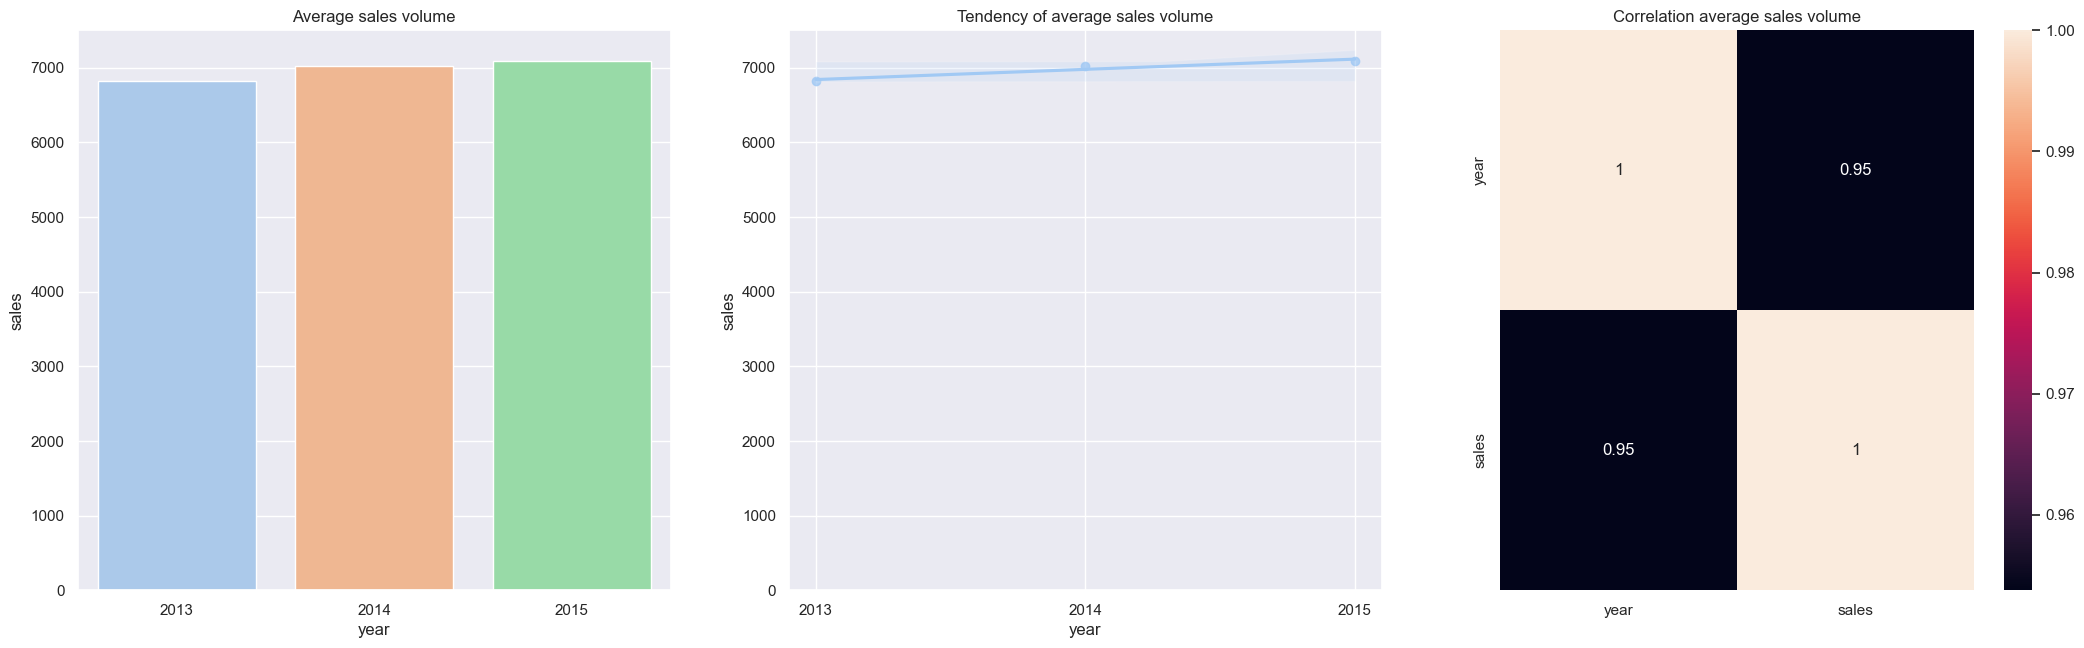

In [41]:
plt.figure(figsize=(26, 16))
aux1 = df4[['year', 'sales']].groupby('year').mean().reset_index()

plt.subplot(2, 3, 1)
ax1 = sns.barplot(data=aux1, x='year', y='sales')
ax1.set_title('Average sales volume')
plt.ylim([0, 7500])

plt.subplot(2, 3, 2)
ax2 = sns.regplot(data=aux1, x='year', y='sales')
ax2.set_title('Tendency of average sales volume')
plt.xticks([2013, 2014, 2015])
plt.ylim([0, 7500])

plt.subplot(2, 3, 3)
ax3 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax3.set_title('Correlation average sales volume')

plt.show()

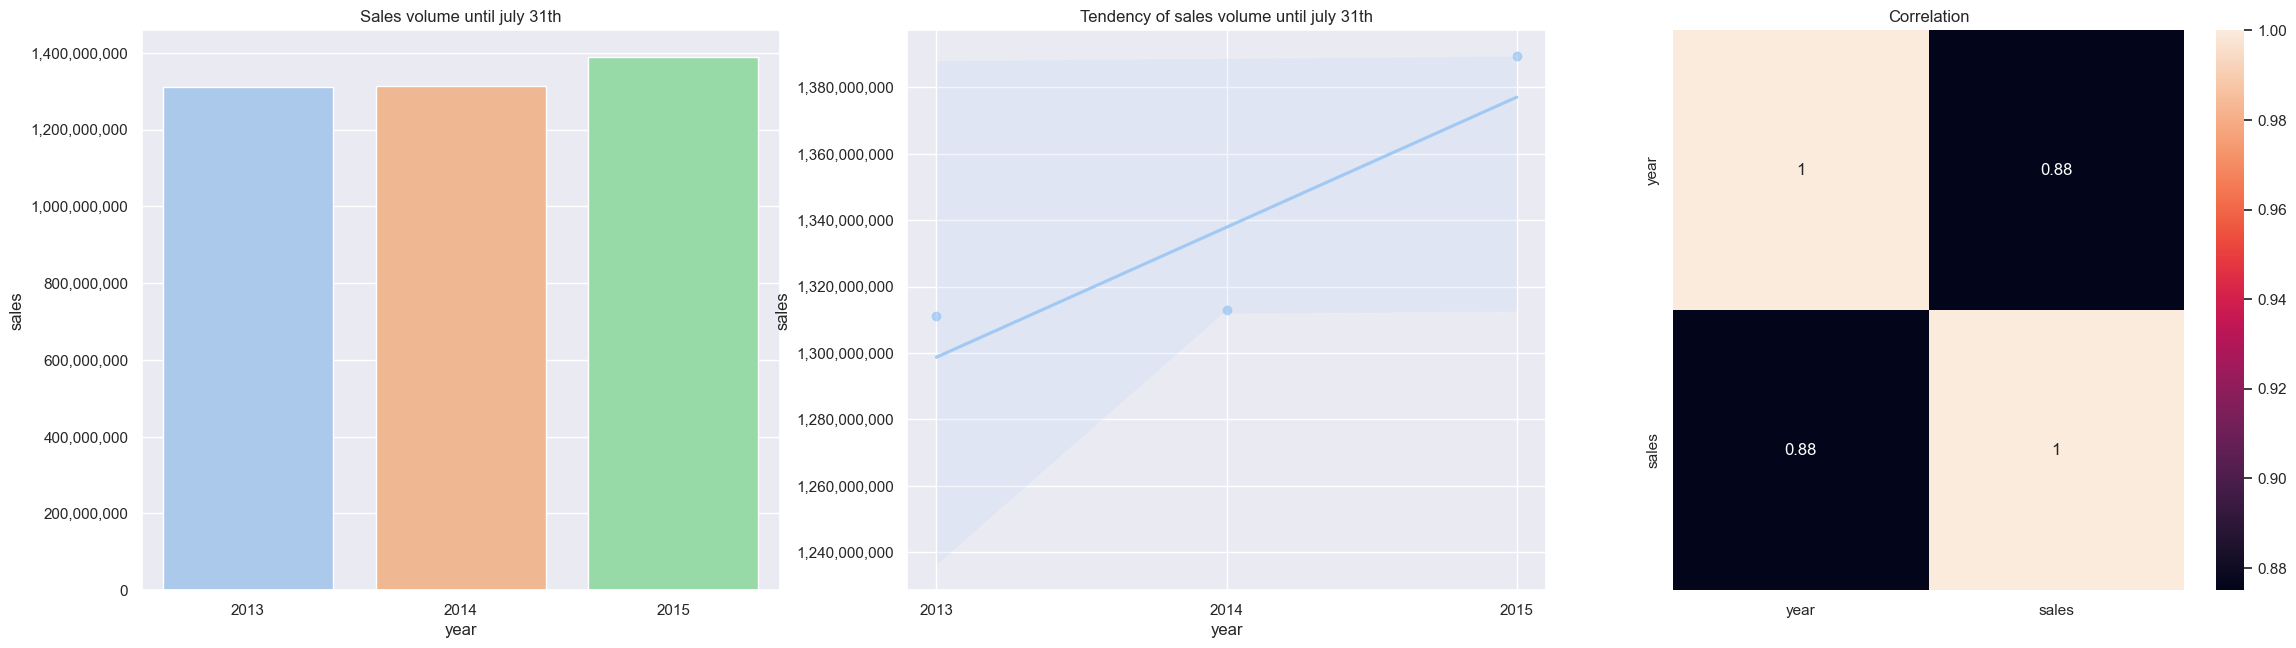

In [42]:
plt.figure(figsize=(28, 16))

f2013 = (df4['date'] >= "2013-01-01") & (df4['date'] <= "2013-07-31")
f2014 = (df4['date'] >= "2014-01-01") & (df4['date'] <= "2014-07-31")
f2015 = (df4['date'] >= "2015-01-01") & (df4['date'] <= "2015-07-31")

aux2 = df4[f2013 | f2014 | f2015][['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(2, 3, 1)
ax1 = sns.barplot(data=aux2, x='year', y='sales')
ax1.set_title('Sales volume until july 31th')
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(2, 3, 2)
ax2 = sns.regplot(data=aux2, x='year', y='sales')
ax2.set_title('Tendency of sales volume until july 31th')
plt.xticks([2013, 2014, 2015])
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(2, 3, 3)
ax3 = sns.heatmap(aux2.corr(method='pearson'), annot=True)
ax3.set_title('Correlation')

plt.show()

### H9. Stores should sell more in the second half of the year
**(TRUE)** - This is true, but only because december have a great amount of sales, which pulls the tendency up throughout the year

It is impossible to compare 2015. So, we will consider only 2013 and 2014.

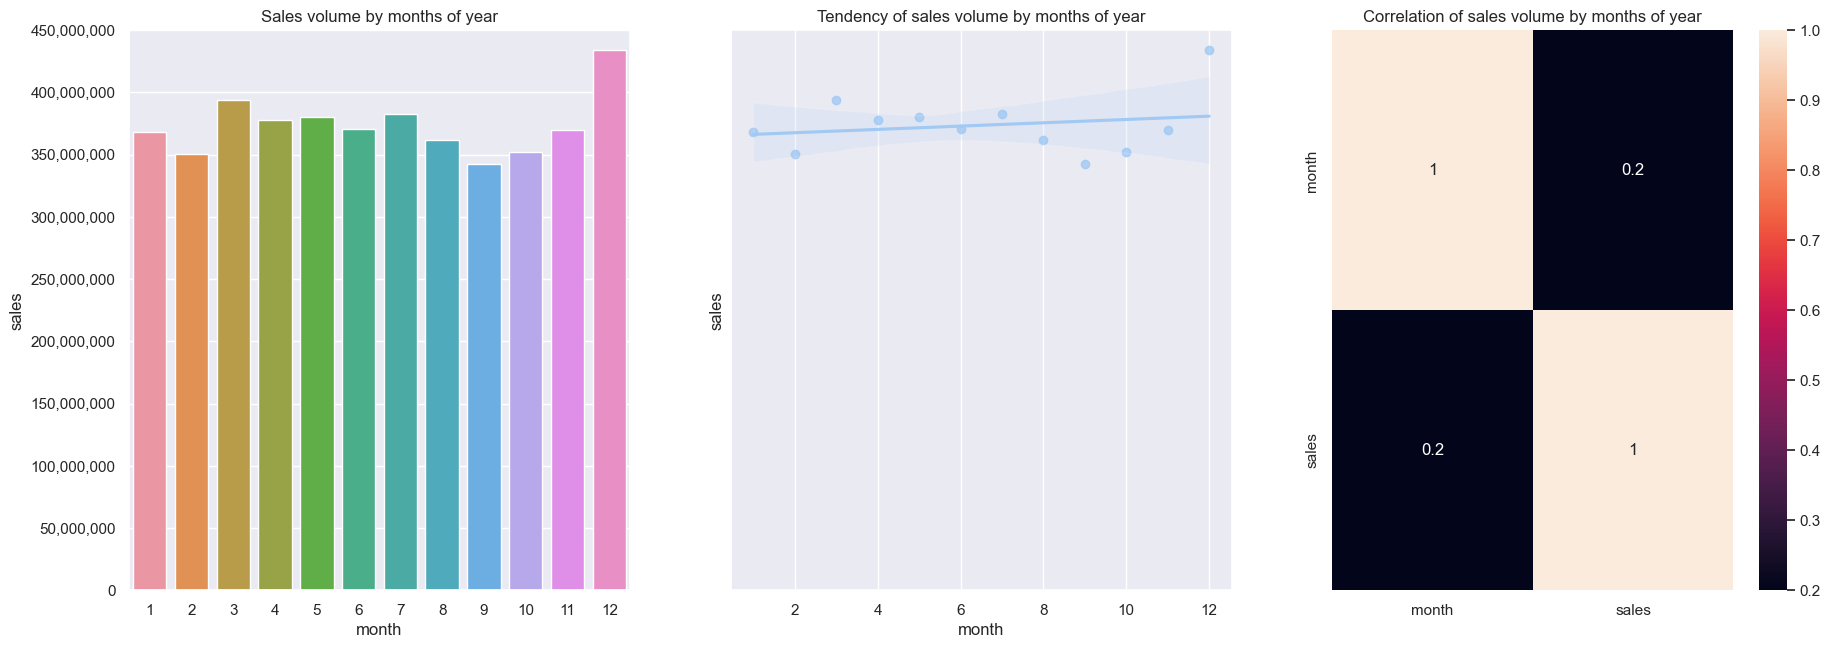

In [43]:
plt.figure(figsize=(22, 16))

aux1 = df4[df4['year'] != 2015][['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(2, 3, 1)
ax1 = sns.barplot(data=aux1, x='month', y='sales')
ax1.set_title('Sales volume by months of year') 
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim([0, 450000000])

plt.subplot(2, 3, 2)
ax2 = sns.regplot(data=aux1, x='month', y='sales')
ax2.set_title('Tendency of sales volume by months of year') 
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim([0, 450000000])
plt.yticks([])

plt.subplot(2, 3, 3)
ax3 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax3.set_title('Correlation of sales volume by months of year') 

plt.show()

### H10. Stores should sell more after the 10th day of each month
**(TRUE)** - The majority of sales happen after the 10th day, but also, we have to consider that we have a larger window in the second half (20 days vs 10 days)

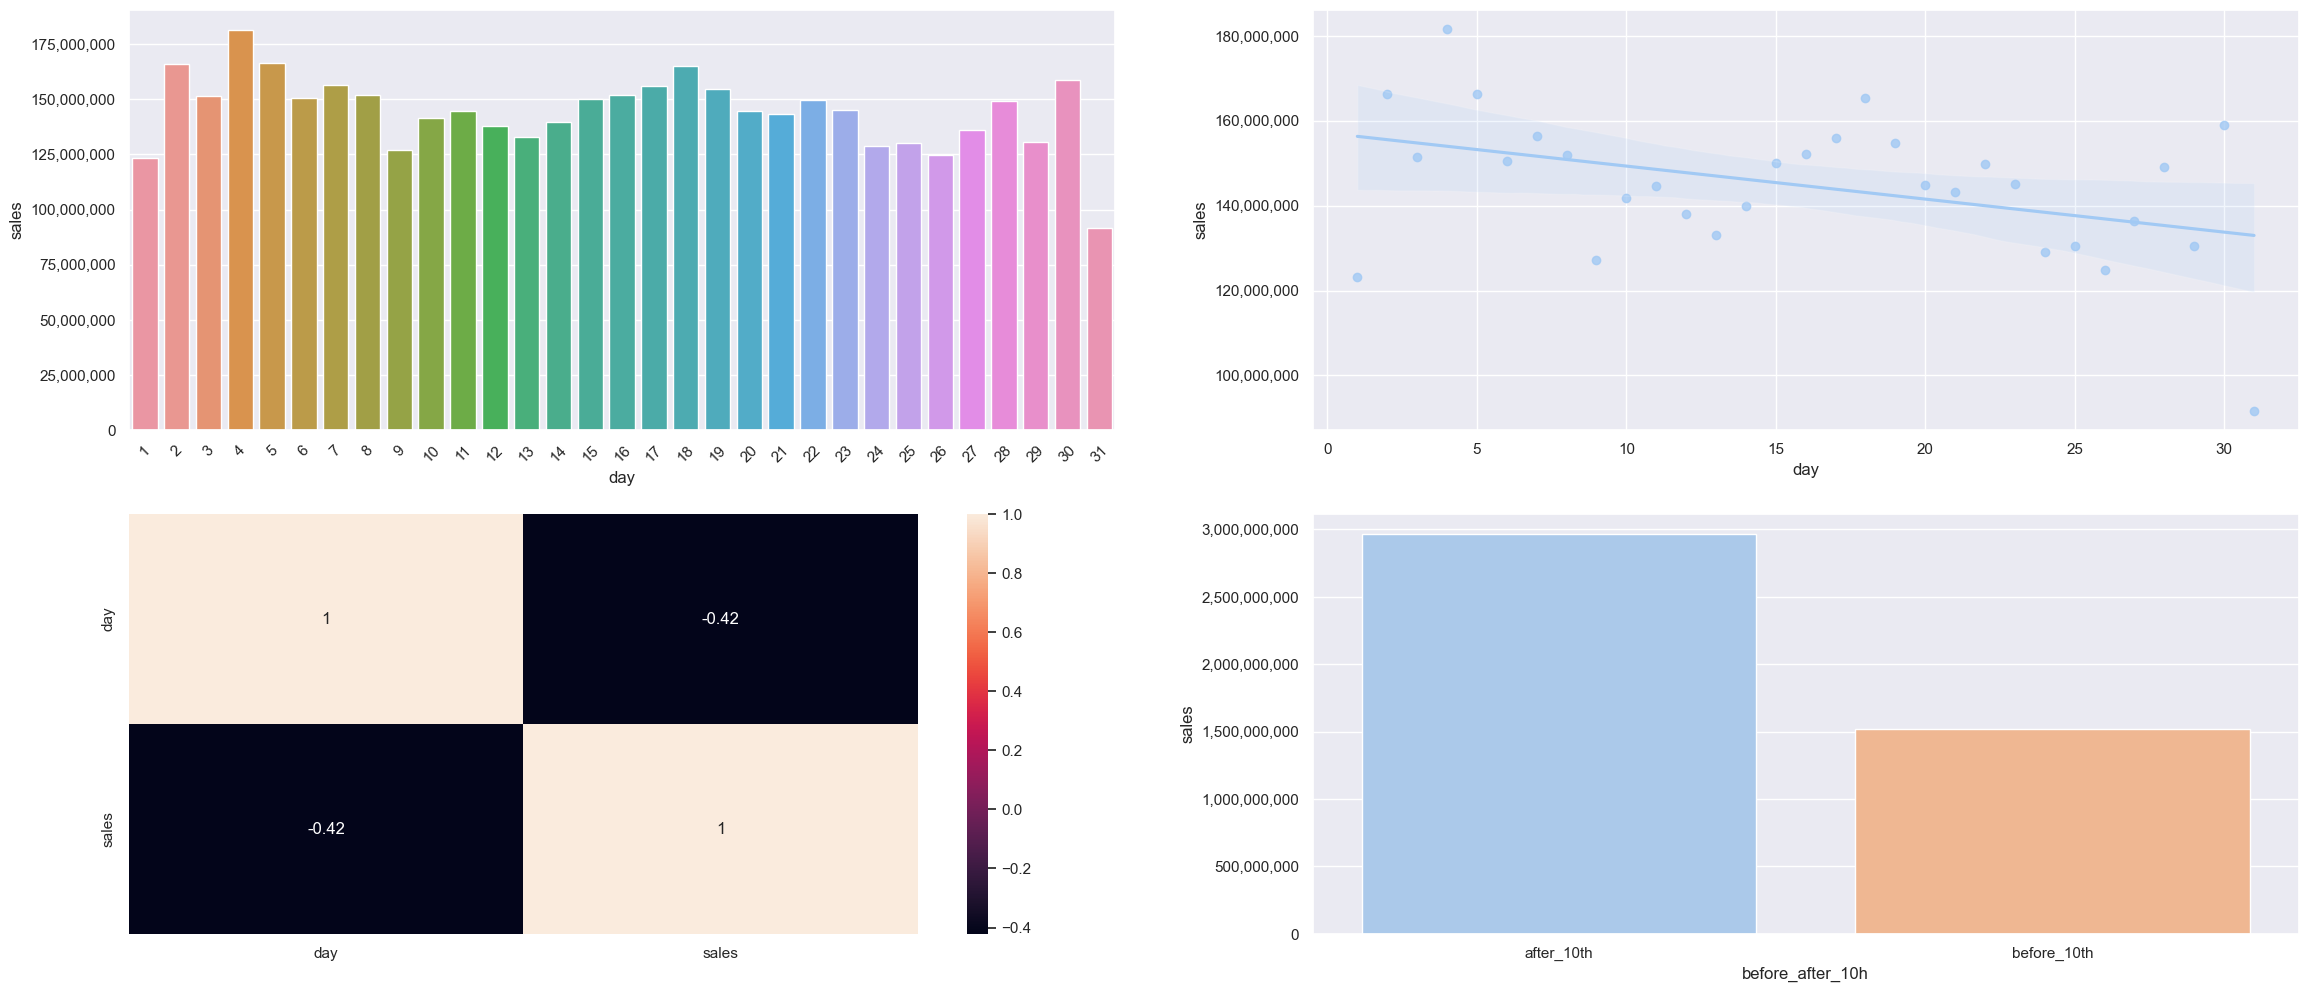

In [44]:
plt.figure(figsize=(28, 12))

aux1 = df4[df4['year'] != 2015][['day', 'sales']].groupby('day').sum().reset_index()
aux1['before_after_10h'] = aux1['day'].apply(lambda x: 'before_10th' if x <=10 else 'after_10th')
aux2 = aux1[['sales', 'before_after_10h']].groupby('before_after_10h').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(data=aux1, x='day', y='sales')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(2, 2, 2)
sns.regplot(data=aux1, x='day', y='sales')
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2, 2, 4)
sns.barplot(data=aux2, x='before_after_10h', y='sales')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

### H11. Stores should sell less on weekends 
**(TRUE)** - On the 6 and 7, the number of sales drops, especially on day 7, which is sunday.

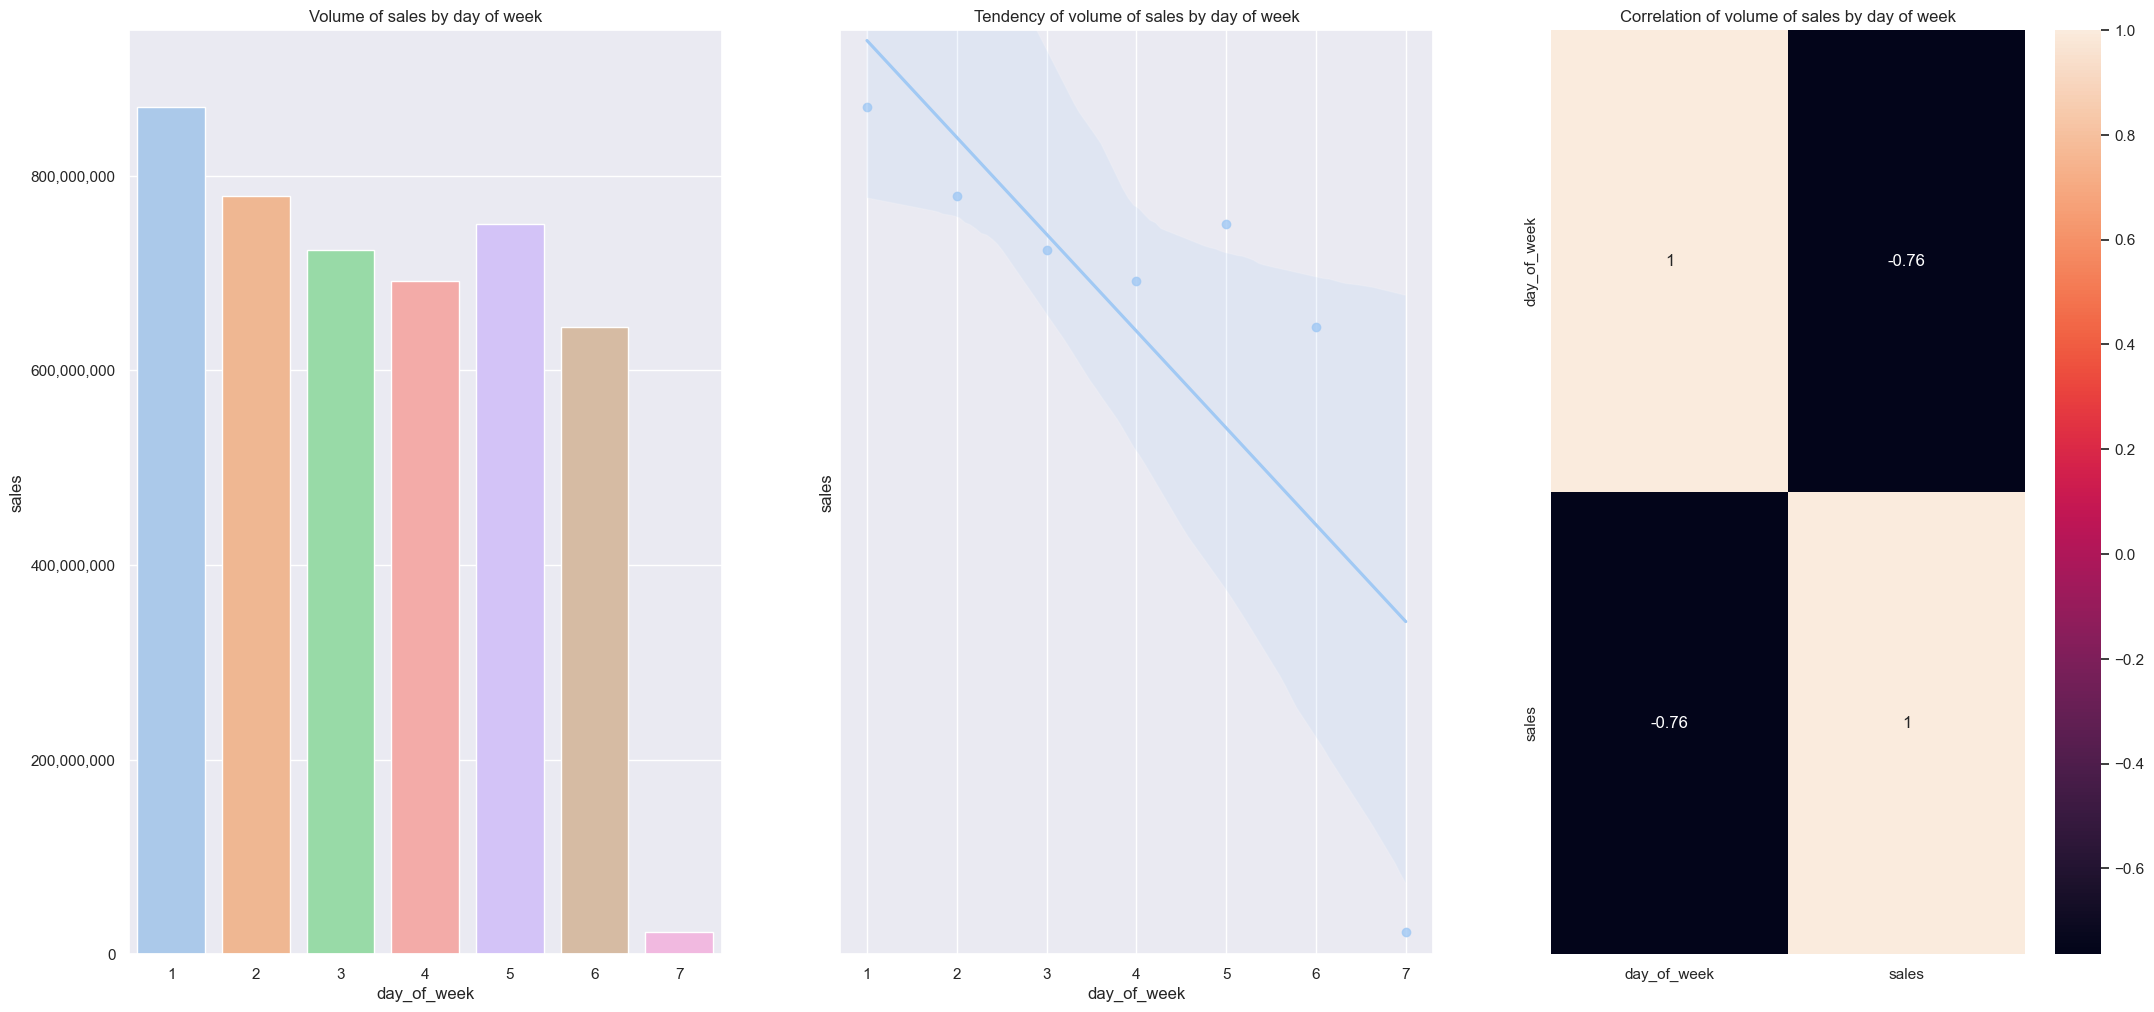

In [45]:
plt.figure(figsize=(26, 12))

aux1 = df4[df4['year'] != 2015][['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
ax1 = sns.barplot(data=aux1, x='day_of_week', y='sales')
ax1.set_title('Volume of sales by day of week')
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim([0, 950000000])

plt.subplot(1, 3, 2)
ax2 = sns.regplot(data=aux1, x='day_of_week', y='sales')
ax2.set_title('Tendency of volume of sales by day of week')
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim([0, 950000000])
plt.yticks([])

plt.subplot(1, 3, 3)
ax3 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax3.set_title('Correlation of volume of sales by day of week')

plt.show()

### H12. Stores should sell less during school holidays
**(TRUE)** - Of course, we have to consider that the majority of time, it is not a school holiday.

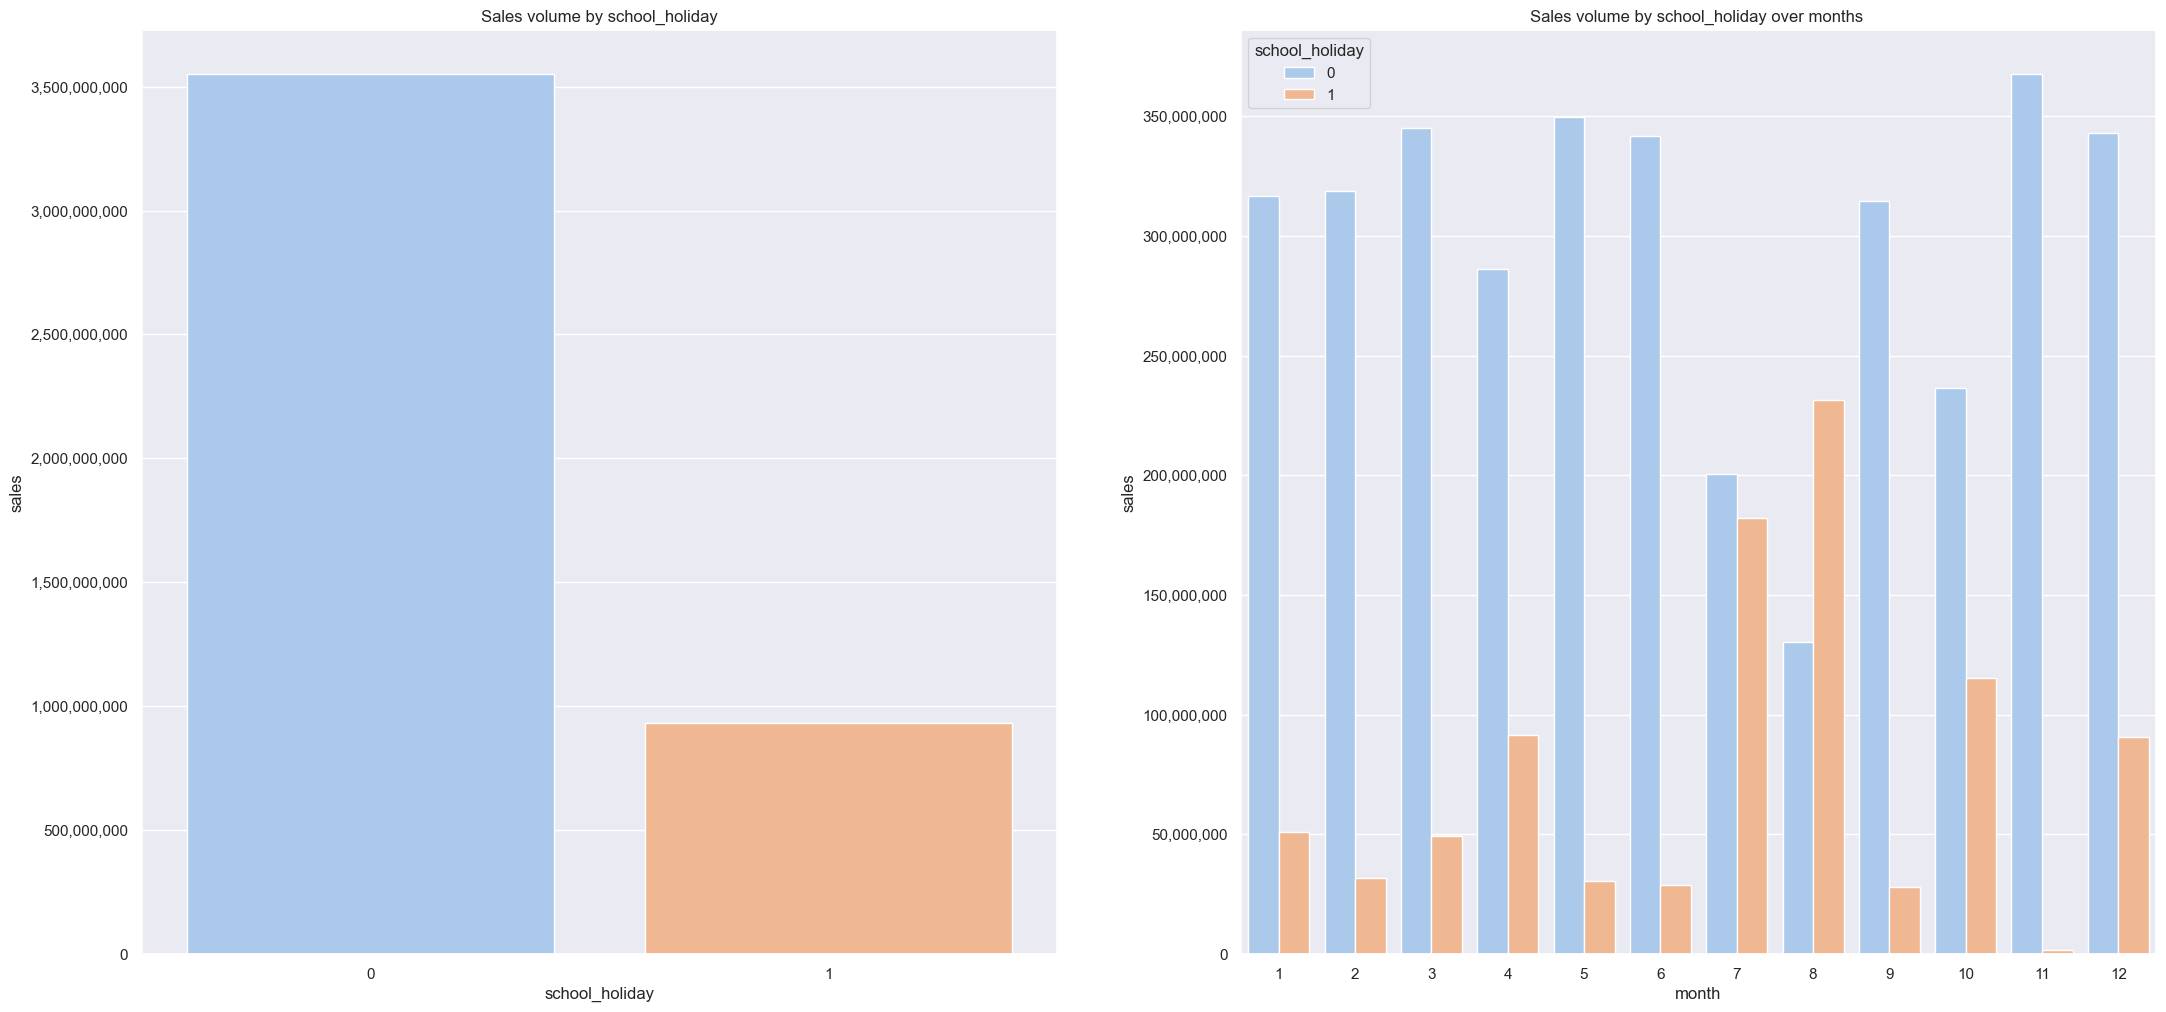

In [46]:
plt.figure(figsize=(26, 12))

aux1 = df4[df4['year'] != 2015][['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=aux1, x='school_holiday', y='sales')
ax1.set_title('Sales volume by school_holiday')
plt.gca().yaxis.set_major_formatter(formatter)

aux2 = df4[df4['year'] != 2015][['school_holiday', 'month', 'sales']].groupby(['school_holiday', 'month']).sum().reset_index()

plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday')
ax2.set_title('Sales volume by school_holiday over months ')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

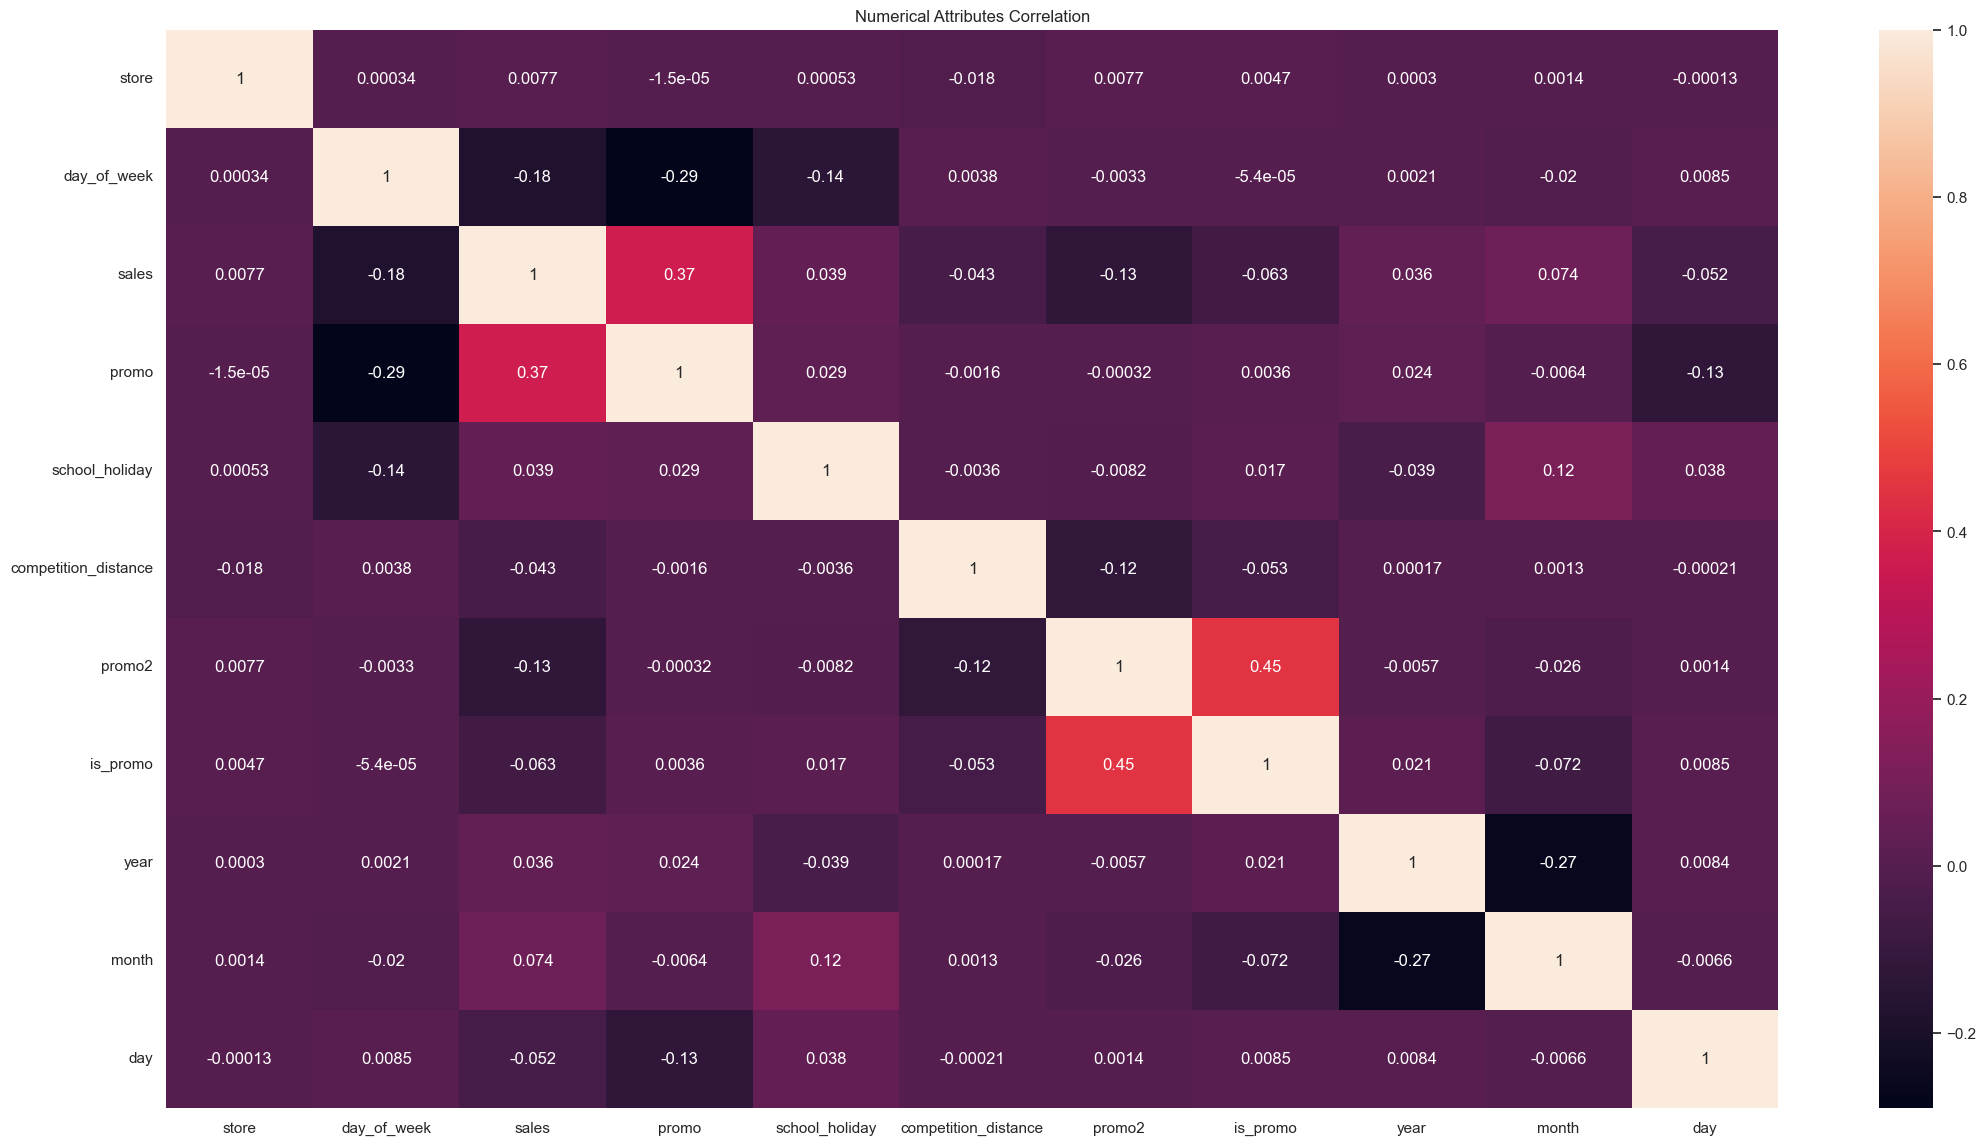

In [47]:
plt.figure(figsize=(26, 14))
correlation = num_att.corr(method='pearson')

ax1 = sns.heatmap(correlation, annot=True)
ax1.set_title('Numerical Attributes Correlation')
plt.show()

### 4.3.2 Categorical Attributes

In [48]:
cat_att = df4.select_dtypes(include=['object'])
cat_att.drop(columns='year_week', inplace=True)

#### 4.3.2.1 Contigency Tables

In [49]:
holiday_vs_store = pd.crosstab(cat_att['state_holiday'], cat_att['store_type'])
holiday_vs_assortment = pd.crosstab(cat_att['state_holiday'], cat_att['assortment'])
store_vs_assortment = pd.crosstab(cat_att['store_type'], cat_att['assortment'])

In [50]:
holiday_vs_store

store_type,a,b,c,d
state_holiday,,,,
christmas,4,66,0,1
easter_holiday,36,100,0,9
no_holiday,456766,15109,112903,258650
public_holiday,236,285,65,108


In [51]:
holiday_vs_assortment

assortment,basic,extended,extra
state_holiday,,,
christmas,28,9,34
easter_holiday,43,48,54
no_holiday,444516,390963,7949
public_holiday,288,234,172


In [52]:
holiday_vs_assortment

assortment,basic,extended,extra
state_holiday,,,
christmas,28,9,34
easter_holiday,43,48,54
no_holiday,444516,390963,7949
public_holiday,288,234,172


#### 4.3.2.1 Calculate Cramer's V

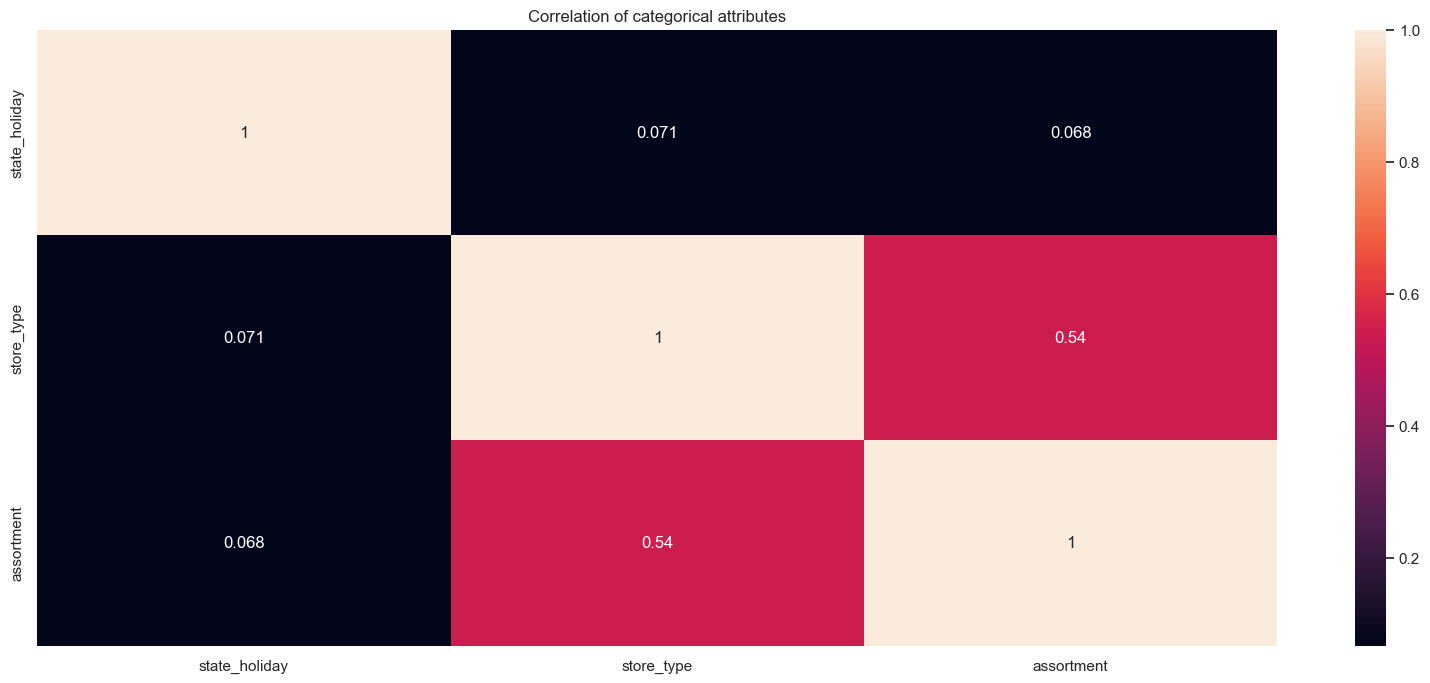

In [53]:
# creating all possible combinations
aux1 = cramers_v(cat_att, 'state_holiday', 'state_holiday')
aux2 = cramers_v(cat_att, 'state_holiday', 'store_type')
aux3 = cramers_v(cat_att, 'state_holiday', 'assortment')

aux4 = cramers_v(cat_att, 'store_type', 'state_holiday')
aux5 = cramers_v(cat_att, 'store_type', 'store_type')
aux6 = cramers_v(cat_att, 'store_type', 'assortment')

aux7 = cramers_v(cat_att, 'assortment', 'state_holiday')
aux8 = cramers_v(cat_att, 'assortment', 'store_type')
aux9 = cramers_v(cat_att, 'assortment', 'assortment')

# create dataset
aux10 = pd.DataFrame({
    'state_holiday': [aux1, aux2, aux3],
    'store_type': [aux4, aux5, aux6],
    'assortment': [aux7, aux8, aux9],
})

# rename index to the same name of columns
aux10 = aux10.set_index(aux10.columns)

# create chart
ax1 = sns.heatmap(aux10, annot=True)
ax1.set_title('Correlation of categorical attributes')
plt.show()

# 5. DATA PREPARATION

In [54]:
df5 = df4.copy()

## 5.1 Normalization

We don't have any feature that follows exactly a normal distribution.

## 5.2 Rescaling

In [55]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_open_since_year
df5['competition_open_since_year'] = rs.fit_transform(df5[['competition_open_since_year']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

# promo2_since_year
df5['promo2_since_year'] = mms.fit_transform(df5[['promo2_since_year']].values)

# competition_number_months
df5['competition_number_months'] = rs.fit_transform(df5[['competition_number_months']].values)

# promo_number_weeks
df5['promo_number_weeks'] = mms.fit_transform(df5[['promo_number_weeks']].values)

## 5.3 Transformation

### 5.3.1 Encoding

In [56]:
# state_holiday
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment
df5['assortment'] = df5['assortment'].apply(lambda x: 1 if x == 'basic' else 2 if x == 'extra' else 3)

### 5.3.2 Transformation

In [57]:
# sales
df5['sales'] = np.log1p(df5['sales'])

In [58]:
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

# week
df5['week_sin'] = df5['week'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df5['week_cos'] = df5['week'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

# promo2_since_week
df5['promo2_since_week_sin'] = df5['promo2_since_week'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df5['promo2_since_week_cos'] = df5['promo2_since_week'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

# competition_open_since_month
df5['competition_open_since_month_sin'] = df5['competition_open_since_month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df5['competition_open_since_month_cos'] = df5['competition_open_since_month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

# 6. FEATURE SELECTION

In [59]:
df6 = df5.copy()

## 6.1 Dropping Features 

In [60]:
cols_drop = ['day', 'month', 'day_of_week', 'week', 'promo2_since_week', 'competition_open_since_month']
df6.drop(cols_drop, axis=1, inplace=True)

## 6.2 Train/Test Split

Our train/test split strategy will be a little different than selecting it randomly. Since we have cyclical data, if we use the random selection strategy, we will have train data blended with test, which may cause overfitting.

Being so, we have set the strategy as selecting **TEST data as all examples of last 6 weeks within dataset**, and **TRAIN test will be previous data**.

The date that represents this breakage is **2015-06-19**

In [61]:
# select train data
X_train = df6.loc[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# select test data
X_test = df6.loc[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

# checking train/test size 
print(f'Original dataset have {df6.shape[0]} rows')
print(f'Train have {(X_train.shape[0]/df6.shape[0]):.2%} and test have {(X_test.shape[0]/df6.shape[0]):.2%}\n')

# checking min-max date of each dataset
print(f'Train min date {X_train["date"].min()}')
print(f'Train max date {X_train["date"].max()}\n')

print(f'Test min date {X_test["date"].min()}')
print(f'Test max date {X_test["date"].max()}')

Original dataset have 844338 rows
Train have 95.10% and test have 4.90%

Train min date 2013-01-01 00:00:00
Train max date 2015-06-18 00:00:00

Test min date 2015-06-19 00:00:00
Test max date 2015-07-31 00:00:00


## 6.3 Boruta implementation

In [62]:
# define random forest regressor
#rf = RandomForestRegressor(n_jobs=-1)

# adjust train and test data as arrays
#X_train_array = X_train.drop(columns=['date', 'sales', 'year_week', 'competition_since_date', 'promo_since'], axis=1).values
#y_train_array = y_train.values.ravel()

# define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1).fit(X_train_array, y_train_array)

In [63]:
# columns index of selected features
#cols_index = list(boruta.support_)

# boruta results
selected_cols = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_year', 'promo2', 'promo2_since_year', 
                 'competition_number_months', 'promo_number_weeks', 'day_sin', 'day_cos', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 
                 'week_cos', 'promo2_since_week_sin', 'promo2_since_week_cos', 'competition_open_since_month_sin', 'competition_open_since_month_cos']

not_selected_cols = ['school_holiday', 'is_promo', 'year', 'state_holiday_christmas', 'state_holiday_easter_holiday', 
                     'state_holiday_no_holiday', 'state_holiday_public_holiday', 'month_sin', 'week_sin']

Taking bivariate analysis as comparasion basis, we can see that the following features was set as relevant:

- assortment
- competition distance
- competition number months
- year
- day
- school holiday

Compating these features with the selected columns, we decided to move forward, with the following changes:
**We will add school holiday, year, week_sin and month_sin in the model**

In [64]:
# cols to add
cols = ['month_sin', 'week_sin']
selected_cols += cols

# 7. MACHINE LEARNING MODELING

In [65]:
# create copies to work with train and test datasets
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [66]:
# dropping date features from train and test dataset
X_train_fs = X_train_copy.drop(columns=['date', 'sales', 'year_week', 'competition_since_date', 'promo_since'], axis=1)
X_test_fs = X_test_copy.drop(columns=['date', 'sales', 'year_week', 'competition_since_date', 'promo_since'], axis=1)

# rearrange train and test datasets to receive the columns that we will use 
X_train = X_train_fs.loc[:, selected_cols]
X_test = X_test_fs.loc[:, selected_cols]

# Adding date column to perform time series cross validation
X_train['date'] = X_train_copy['date']
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

## 7.1 Average

In [67]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# predict
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_average = aux1['predictions']

# performance 
baseline_result = ml_performance('average_model', np.expm1(y_test), np.expm1(yhat_average))
baseline_result

,model_name,MAE,MAPE,RMSE,R2_SCORE
0,average_model,1354.8,0.2064,1835.14,0.6366


## 7.2 Linear Regression

### 7.2.1 Single Fold

In [68]:
# model
lr = LinearRegression()

# train
lr.fit(X_train.iloc[:, :-1], y_train)

# predict
yhat_lr = lr.predict(X_test)

# performance
lr_result = ml_performance('linear_regression_model', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,model_name,MAE,MAPE,RMSE,R2_SCORE
0,linear_regression_model,1865.94,0.2907,2678.67,0.2256


### 7.2.2 Cross Validation

In [69]:
lr_cv = cross_validation_ts(X_train, y_train, 'linear_regression', lr)
lr_cv

,MODEL,MAE_avg,MAPE_avg,RMSE_avg,R2_avg
0,linear_regression,2036.93 +/- 98.96,0.34 +/- 0.02,2839.5 +/- 165.09,0.16 +/- 0.03


## 7.3 Linear Regression Regularized - Lasso

### 7.3.1 Single Fold

In [70]:
# model
llr = Lasso(alpha=0.01)

# train
llr.fit(X_train.iloc[:, :-1], y_train)

# predict
yhat_llr = llr.predict(X_test)

# performance
llr_result = ml_performance('lasso_linear_regression_model', np.expm1(y_test), np.expm1(yhat_llr))
llr_result

,model_name,MAE,MAPE,RMSE,R2_SCORE
0,lasso_linear_regression_model,1900.05,0.2887,2765.84,0.1744


### 7.3.2 Cross Validation

In [71]:
lasso_cv = cross_validation_ts(X_train, y_train, 'lasso_regression', llr)
lasso_cv

,MODEL,MAE_avg,MAPE_avg,RMSE_avg,R2_avg
0,lasso_regression,2007.8 +/- 83.26,0.32 +/- 0.01,2861.66 +/- 169.03,0.15 +/- 0.03


## 7.4 Random Forest Regressor

### 7.4.1 Single Fold

In [72]:
# model
rfr = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)

# train
rfr.fit(X_train.iloc[:, :-1], y_train)

# predict
yhat_rfr = rfr.predict(X_test)

# performance
rfr_result = ml_performance('random_forest_regressor_model', np.expm1(y_test), np.expm1(yhat_rfr))
rfr_result

,model_name,MAE,MAPE,RMSE,R2_SCORE
0,random_forest_regressor_model,671.27,0.0993,998.28,0.8924


### 7.4.2 Cross Validation

In [73]:
rfr_cv = cross_validation_ts(X_train, y_train, 'random_forest_regressor',  rfr)
rfr_cv

,MODEL,MAE_avg,MAPE_avg,RMSE_avg,R2_avg
0,random_forest_regressor,1004.26 +/- 204.47,0.15 +/- 0.02,1605.11 +/- 371.38,0.73 +/- 0.1


## 7.5 XGBoost Regressor

###  7.5.1 Single Fold

In [74]:
# model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, eta=0.01, subsample=0.7, colsample_bytree=0.9)

# train
xgb_model.fit(X_train.iloc[:, :-1], y_train)

# predict
yhat_xgb = xgb_model.predict(X_test)

# performance
xgb_result = ml_performance('xgb_regressor_model', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,model_name,MAE,MAPE,RMSE,R2_SCORE
0,xgb_regressor_model,6953.07,0.993,7589.43,-5.2162


### 7.5.2 Cross Validation

In [75]:
xgb_cv = cross_validation_ts(X_train, y_train, 'xgb_regressor', xgb_model)
xgb_cv

,MODEL,MAE_avg,MAPE_avg,RMSE_avg,R2_avg
0,xgb_regressor,6870.17 +/- 216.07,0.99 +/- 0.0,7538.64 +/- 246.51,-4.9 +/- 0.19


## 7.6 Performance

### 7.6.1 Single Fold Performance

In [76]:
modeling_perf = pd.concat([baseline_result, lr_result, llr_result, rfr_result, xgb_result], ignore_index=True)
modeling_perf.sort_values('RMSE')

,model_name,MAE,MAPE,RMSE,R2_SCORE
3,random_forest_regressor_model,671.27,0.0993,998.28,0.8924
0,average_model,1354.80,0.2064,1835.14,0.6366
1,linear_regression_model,1865.94,0.2907,2678.67,0.2256
2,lasso_linear_regression_model,1900.05,0.2887,2765.84,0.1744
4,xgb_regressor_model,6953.07,0.9930,7589.43,-5.2162


### 7.6.2 Cross Validation Performance

In [77]:
cv_perf = pd.concat([lr_cv, lasso_cv, rfr_cv, xgb_cv], ignore_index=True)
cv_perf.sort_values('RMSE_avg')

,MODEL,MAE_avg,MAPE_avg,RMSE_avg,R2_avg
2,random_forest_regressor,1004.26 +/- 204.47,0.15 +/- 0.02,1605.11 +/- 371.38,0.73 +/- 0.1
0,linear_regression,2036.93 +/- 98.96,0.34 +/- 0.02,2839.5 +/- 165.09,0.16 +/- 0.03
1,lasso_regression,2007.8 +/- 83.26,0.32 +/- 0.01,2861.66 +/- 169.03,0.15 +/- 0.03
3,xgb_regressor,6870.17 +/- 216.07,0.99 +/- 0.0,7538.64 +/- 246.51,-4.9 +/- 0.19


The choosen algorithm is **Random Forest Regressor**

# 8 HYPER PARAMETERS FINE TUNNING

## 8.1 Random Search

In [78]:
# create a dictionary of parameter values values
#params = {'n_estimators': [1000, 1500, 2000, 2500],
          #'max_depth': [15, 30, 45, 60],
          #'max_features': [5, 10, 15, 'sqrt', 'log2']}

# select the number of intervals
#max_eval = 10

In [79]:
# create an empty dataframe to save results
#final_result = pd.DataFrame()

# run fine tunning
#for i in range(max_eval):
    
    # randonly choose values
    #ft = {key: random.sample(value, 1)[0] for key, value in params.items()}
    #print(f'{i}th iteraction: ')
    #print(f'{ft}')
    #print('---------\n')

    # create model
    #rfr_ft = RandomForestRegressor(n_estimators=ft['n_estimators'], 
                                   #max_depth=ft['max_depth'],
                                   #max_features= ft['max_features'],
                                   #n_jobs=-1, 
                                   #random_state=42)

    # performance
    #result = cross_validation_ts(X_train, y_train, f'{i}th_iteraction', rfr_ft)
    #final_result = pd.concat([final_result, result])

## 8.2 Final Model

**Params:**
{'n_estimators': 2000, 'max_depth': 70, 'max_features': 15}

In [80]:
# create model
model = RandomForestRegressor(n_estimators=2000,
                              max_depth=70,
                              max_features=15)

# train
model.fit(X_train.iloc[:, :-1], y_train)

# predict
yhat = model.predict(X_test)

# performance
model_result = ml_performance('random_forest_regressor', np.expm1(y_test), np.expm1(yhat))

MemoryError: could not allocate 58720256 bytes

In [81]:
model_result

NameError: name 'model_result' is not defined

In [82]:
np.zeros(dtype=int)

TypeError: zeros() missing required argument 'shape' (pos 0)

In [85]:
int

int